<a href="https://colab.research.google.com/github/mayafetzer/CoffeeResearch/blob/main/CHEG472_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maya Fetzer

CHEG472

Machine Learning Individual Project

The goal of this project is to create a machine learning model that will predict the freshness of coffee based on how old is it. The model will be trained on a sample dataset of experimental data that I have collected as part of my individual research project with Dr. Kat Wakabayashi.

## Step 1: Download and preprocess the dataset

In order to make a machine learning model, you need a dataset in order to train the model. For this project, I will be using a dataset that I have collected as a part of my independant research.

In [ ]:
import pandas as pd

# Replace '/path/to/your/file.xlsx' with the actual file path
file_path = '/content/Coffee_Freshness_Dataset_FA2024.xlsx'

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path)

# Print the first few rows of the DataFrame
print("The first 5 rows of the dataset:")
print(df.head())

# Print the description of the DataFrame
print("The descriptive statistics of the dataset")
print(df.describe())

# Get the data types of all columns
data_types = df.dtypes
# Print the datatypes of each column
print("The data types of each column:")
print(data_types)

# Get the numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Get the categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
# Print the results
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

The first 5 rows of the dataset:
        Date  Sample Age (days)  Triplicate_#  Roast Level (%)  \
0 2024-09-24                  0             1            0.135   
1 2024-09-24                  0             2            0.135   
2 2024-09-24                  0             3            0.135   
3 2024-09-24                  0             1            0.207   
4 2024-09-24                  0             2            0.207   

   FTIR Lipid Absorbance  FTIR Carboxylic Acid Absorbance  FTIR Peak Ratio  \
0                 0.0766                           0.0466         1.643777   
1                 0.0815                           0.0465         1.752688   
2                 0.0912                           0.0531         1.717514   
3                 0.0882                           0.0532         1.657895   
4                 0.0918                           0.0546         1.681319   

   GCMS 2-Methylfuran Area (%)  GCMS Methanethiol Area (%)  GCMS Peak Ratio  \
0                     

In [ ]:
# Remove the redundant data columns that are not relevant to the dataset

# For this dataset, I am going to remove the actual date. This does not matter,
# only the number of days since the roast date. Next, I am going to drop the hardness
# column because it only says "no", which is because we weren't able to
# collect this data. I am also going to the triplicate
# number, as this was only meant to help organize the samples while collecting them.

# Finally, I am going to remove the TGA/DSC DH values, because these ended up
# not being something that we could map back to aspects of coffee freshness over
# time in the literature
df = df.drop(columns=['Date', 'Triplicate_#','TGA/DSC DH 250-360, 200-360','Hardness'])

Before I can use a machine learning model, I need to make sure that the dataset has no factors that would skew the model. So, I will be looking at removing redundancies, outliers, missing data, etc. and doing some dimensional reduction and normalization of the variables in order to make the dataset ideal for modeling.

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Check for missing data
missing_data = df.isnull().sum()
print("Total missing values for each column before filling:")
print(missing_data[missing_data > 0])

# There is no missing data in this dataset, so we don't have to worry about handling
# missing values.

Total missing values for each column before filling:
Series([], dtype: int64)


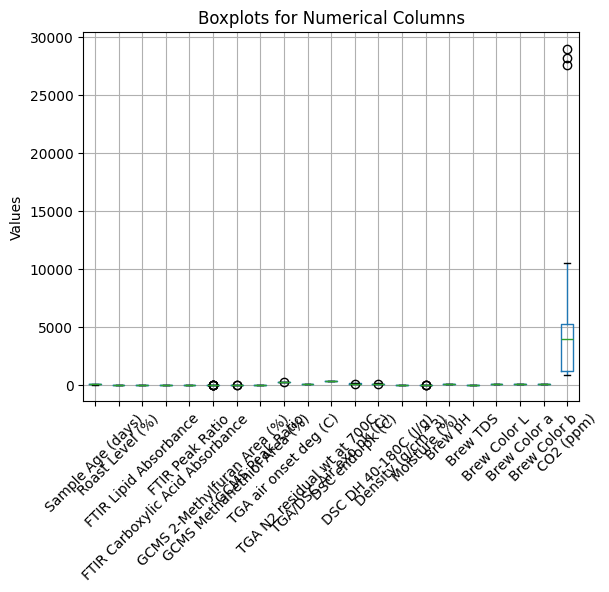

No outliers found in column 'Sample Age (days)'
No outliers found in column 'Roast Level (%)'
No outliers found in column 'FTIR Lipid Absorbance'
No outliers found in column 'FTIR Carboxylic Acid Absorbance'
No outliers found in column 'FTIR Peak Ratio'
Outliers in column 'GCMS 2-Methylfuran Area (%)': [0.0, 0.0, 0.0, 0.5095999999999999, 0.6425, 0.4764]
Outliers in column 'GCMS Methanethiol Area (%)': [0.0356, 0.0331]
No outliers found in column 'GCMS Peak Ratio'
Outliers in column 'TGA air onset deg (C)': [236.11]
No outliers found in column 'TGA N2 residual wt at 700C'
No outliers found in column 'TGA/DSC Air exo pk (C)'
Outliers in column 'DSC endo pk (C)': [69.02]
Outliers in column 'DSC DH 40-180C (J/g)': [19.33]
No outliers found in column 'Density (g/cm^3)'
Outliers in column 'Moisture (%)': [0.005, 0.004, 0.0075]
No outliers found in column 'Brew pH'
No outliers found in column 'Brew TDS'
No outliers found in column 'Brew Color L'
No outliers found in column 'Brew Color a'
No o

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate outliers for each column
outliers_dict = {}

# Only check the columns that are numerical and would contain outliers
columns_to_check = df.select_dtypes(include=['int64', 'float64']).columns

# Create boxplots for specified columns
df[columns_to_check].boxplot()
plt.title("Boxplots for Numerical Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()

# Check for outliers and plot the boxplot
for col in columns_to_check:
   q1 = np.quantile(df[col], 0.25)
   q3 = np.quantile(df[col], 0.75)
   iqr = q3 - q1
   lower_bound = q1 - 1.5 * iqr
   upper_bound = q3 + 1.5 * iqr
   outliers = df[col][(df[col] < lower_bound) | (df[col] > upper_bound)]
   outliers_dict[col] = outliers.tolist()

# Print outliers for each column
for col, outliers in outliers_dict.items():
   if outliers:
       print(f"Outliers in column '{col}': {outliers}")
   else:
       print(f"No outliers found in column '{col}'")

# This dataset does have outliers, but I am going to choose to not remove them.
# At this point, the dataset is very small, and so removing the outliers
# removes some important information about the trends of the data that
# I think will be important to keep going forward.

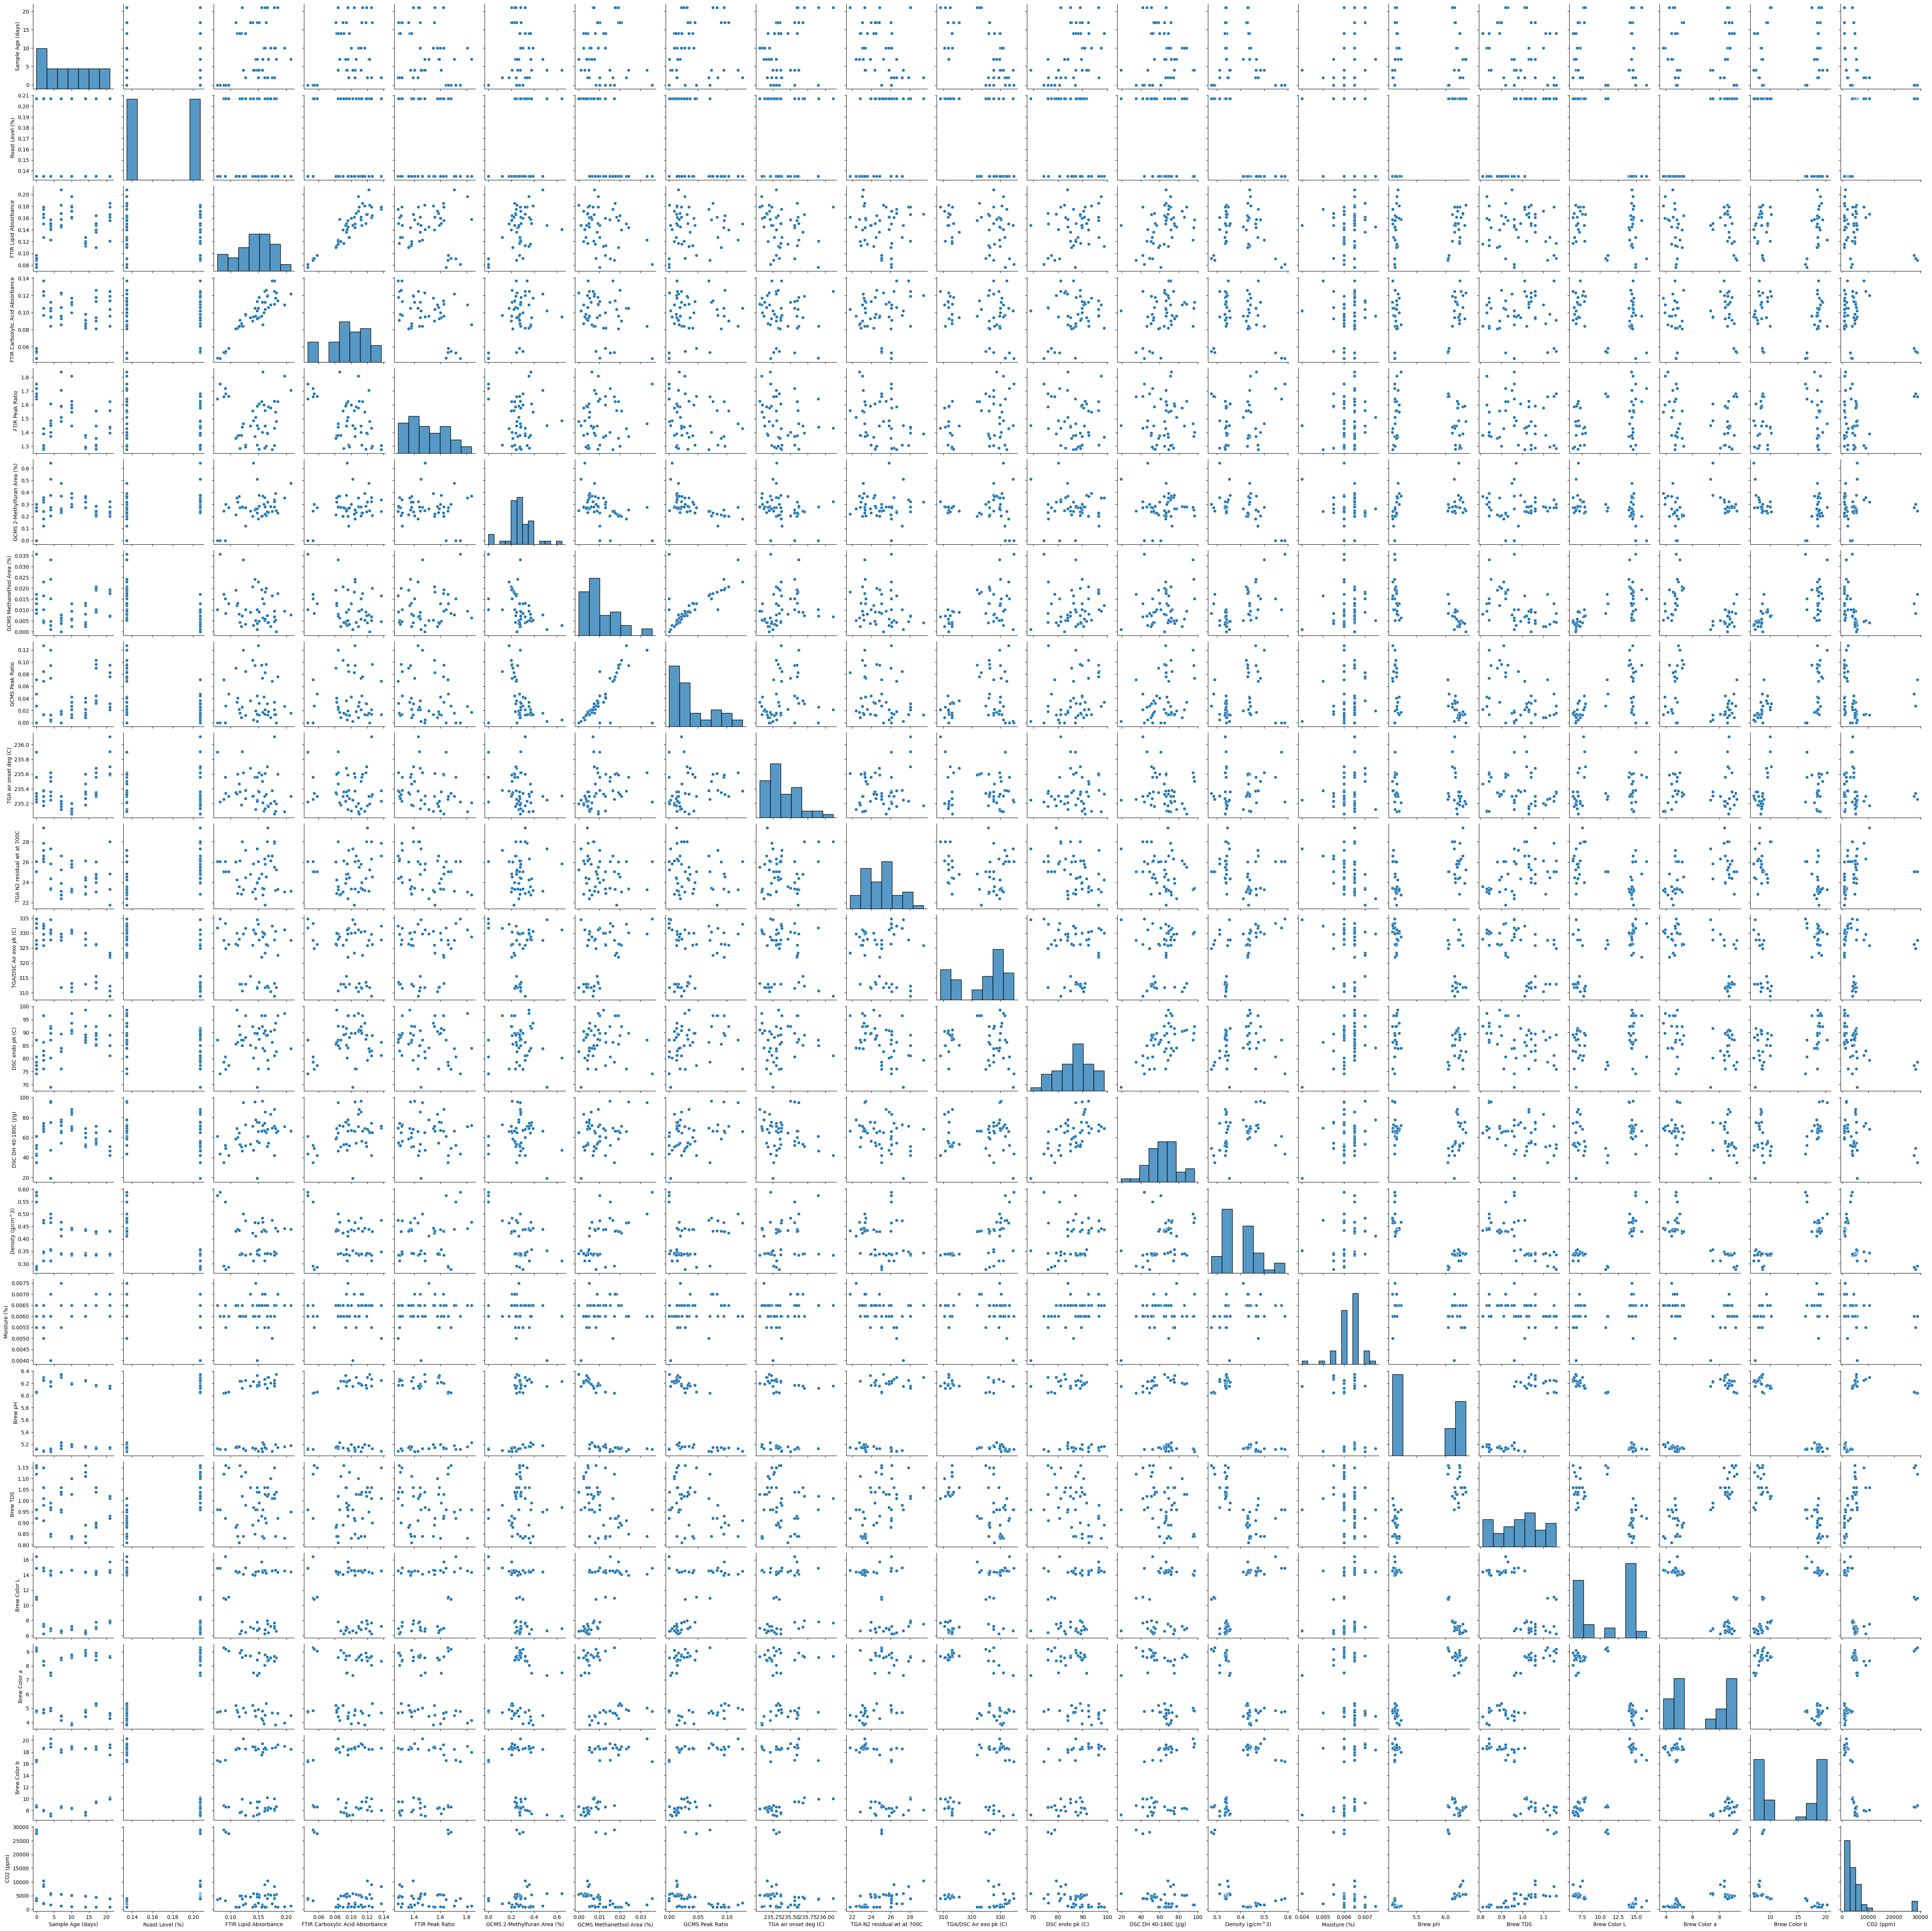

In [ ]:
# To better understand the trends of the data, I want to then look at the
# pairplots to better understand if there are variables that relate strongly
# with one another. This will be helpful when I need to go through and
# reduce the dataset to make it more fit for machine learning analysis.

import seaborn as sns
sns.pairplot(df)

                                 Sample Age (days)  Roast Level (%)  \
Sample Age (days)                     1.000000e+00     1.560582e-16   
Roast Level (%)                       1.560582e-16     1.000000e+00   
FTIR Lipid Absorbance                 2.487824e-01     4.493847e-02   
FTIR Carboxylic Acid Absorbance       2.815636e-01     1.350734e-01   
FTIR Peak Ratio                      -2.421832e-01    -1.955946e-01   
GCMS 2-Methylfuran Area (%)           5.323967e-02     3.026838e-01   
GCMS Methanethiol Area (%)           -4.191001e-02    -6.165070e-01   
GCMS Peak Ratio                       1.754880e-01    -4.876684e-01   
TGA air onset deg (C)                 3.897055e-01    -6.230424e-02   
TGA N2 residual wt at 700C           -1.868016e-01     4.737316e-01   
TGA/DSC Air exo pk (C)               -5.666206e-01    -6.545111e-01   
DSC endo pk (C)                       5.090838e-01    -3.696760e-01   
DSC DH 40-180C (J/g)                 -8.687521e-02    -3.607031e-01   
Densit

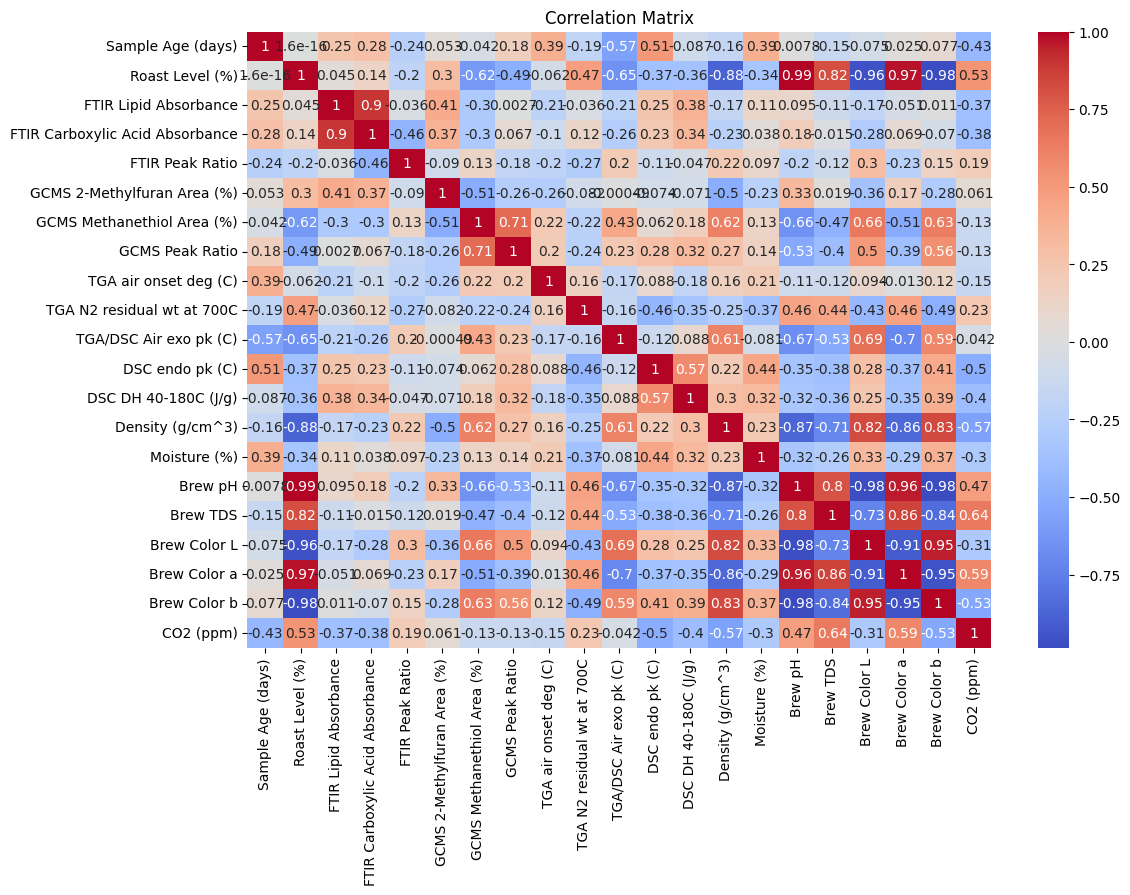

             feature1           feature2  correlation
0   Sample Age (days)  Sample Age (days)     1.000000
1     Roast Level (%)    Roast Level (%)     1.000000
2     Roast Level (%)   Density (g/cm^3)    -0.879210
3     Roast Level (%)            Brew pH     0.992888
4     Roast Level (%)           Brew TDS     0.818748
..                ...                ...          ...
62       Brew Color b           Brew TDS    -0.835178
63       Brew Color b       Brew Color L     0.947015
64       Brew Color b       Brew Color a    -0.949133
65       Brew Color b       Brew Color b     1.000000
66          CO2 (ppm)          CO2 (ppm)     1.000000

[67 rows x 3 columns]


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Analyze significant correlations
significant_correlations = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
significant_correlations = significant_correlations.stack().reset_index()
significant_correlations.columns = ['feature1', 'feature2', 'correlation']
print(significant_correlations)

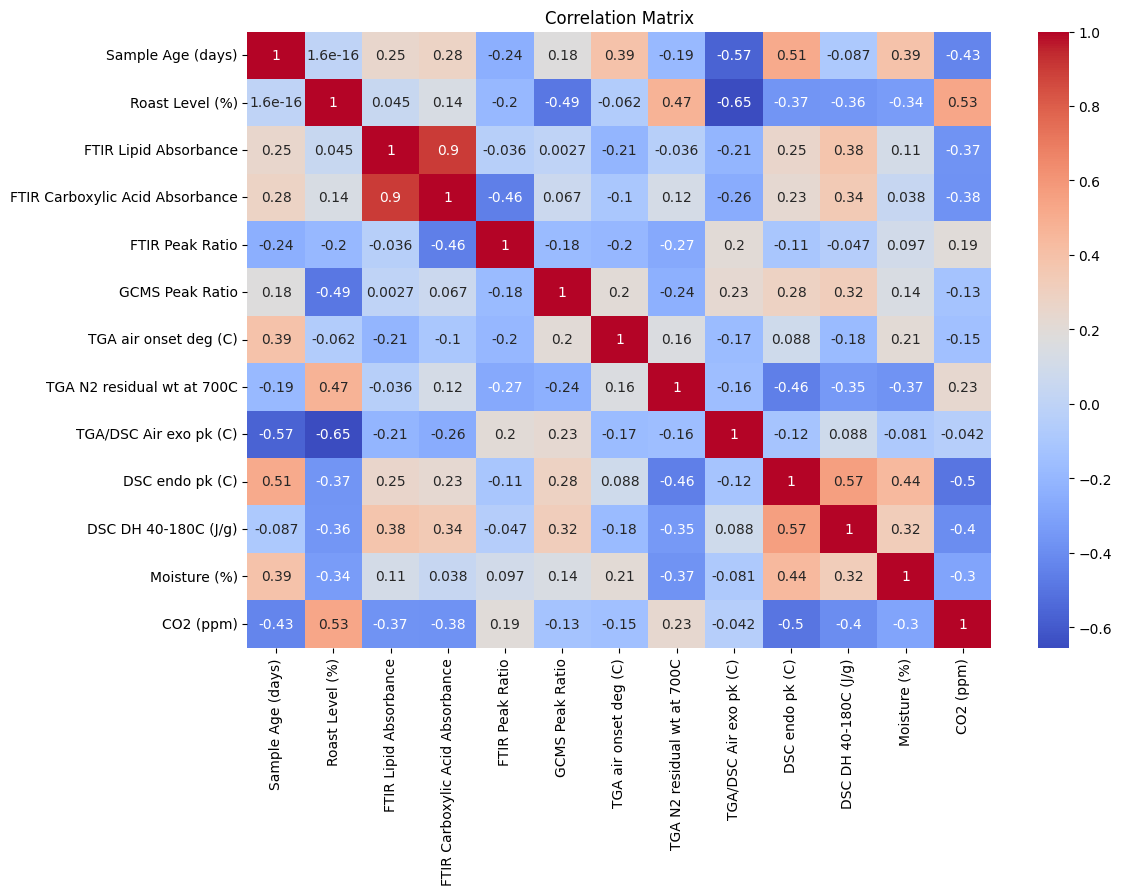

In [ ]:
# Now I will remove anything will a low correlation to time to avoid overfitting.
df.drop(['GCMS 2-Methylfuran Area (%)','GCMS Methanethiol Area (%)', 'Brew pH','Brew TDS','Brew Color L','Brew Color a','Brew Color b','Density (g/cm^3)'],axis=1, inplace=True)

# Calculate the new correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize new correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Next, we need to deal with multicollinearity within the dataset. This is
# when two or more variables are highly correlated with one another. If you
# leave these as seperate terms, it can skew the model and lead to distortion.

# Terms with interaction:
# Acidity: FTIR Carboxylic Acid Absorbance + FTIR Lipid Absorbance
# Aroma: GCMS Ratio
df['Aroma'] = df['GCMS Peak Ratio']
df['Acidity'] = df['FTIR Carboxylic Acid Absorbance'] * df['FTIR Lipid Absorbance']
df['Oxidation'] = df['DSC endo pk (C)'] * df['TGA N2 residual wt at 700C']

# Now we drop everything that was combined together
df.drop(['FTIR Carboxylic Acid Absorbance', 'FTIR Lipid Absorbance','DSC endo pk (C)','TGA N2 residual wt at 700C','TGA/DSC Air exo pk (C)'], axis=1, inplace=True)

In [ ]:
# Because we removed the multicollinearity because the GCMS and the FTIR peaks,
# I am also going to remove the FTIR peak ratio sections of this datasheet.
# This way we won't have duplicates of the data.
df.drop(['FTIR Peak Ratio','GCMS Peak Ratio'], axis=1, inplace=True)

# To avoid overfitting, we can drop relationships that are not strongly correlated
# with time.

df.drop(['DSC DH 40-180C (J/g)'],axis=1, inplace=True)

# I am also going to rename "TGA air onset deg (C)" because that name is, while
# representative of what we measured, not very clear in how it relates to the
# freshness of the coffee.

df['Oil Expression'] = df['TGA air onset deg (C)']
df.drop(['TGA air onset deg (C)'],axis=1, inplace=True)

   Sample Age (days)  Roast Level (%)  Moisture (%)  CO2 (ppm)     Aroma  \
0                  0            0.135        0.0065       3520  0.000000   
1                  0            0.135        0.0060       3930  0.000000   
2                  0            0.135        0.0065       3131  0.000000   
3                  0            0.207        0.0060      28980  0.070823   
4                  0            0.207        0.0055      28182  0.027978   

    Acidity  Oxidation  Oil Expression  
0  0.003570  2269.8260          235.90  
1  0.003790  1934.9550          235.22  
2  0.004843  2102.3905          235.56  
3  0.004692  1971.7208          235.26  
4  0.005012  1902.8058          235.34  
                   Sample Age (days)  Roast Level (%)  Moisture (%)  \
Sample Age (days)       1.000000e+00     1.560582e-16      0.388316   
Roast Level (%)         1.560582e-16     1.000000e+00     -0.335643   
Moisture (%)            3.883160e-01    -3.356434e-01      1.000000   
CO2 (ppm)    

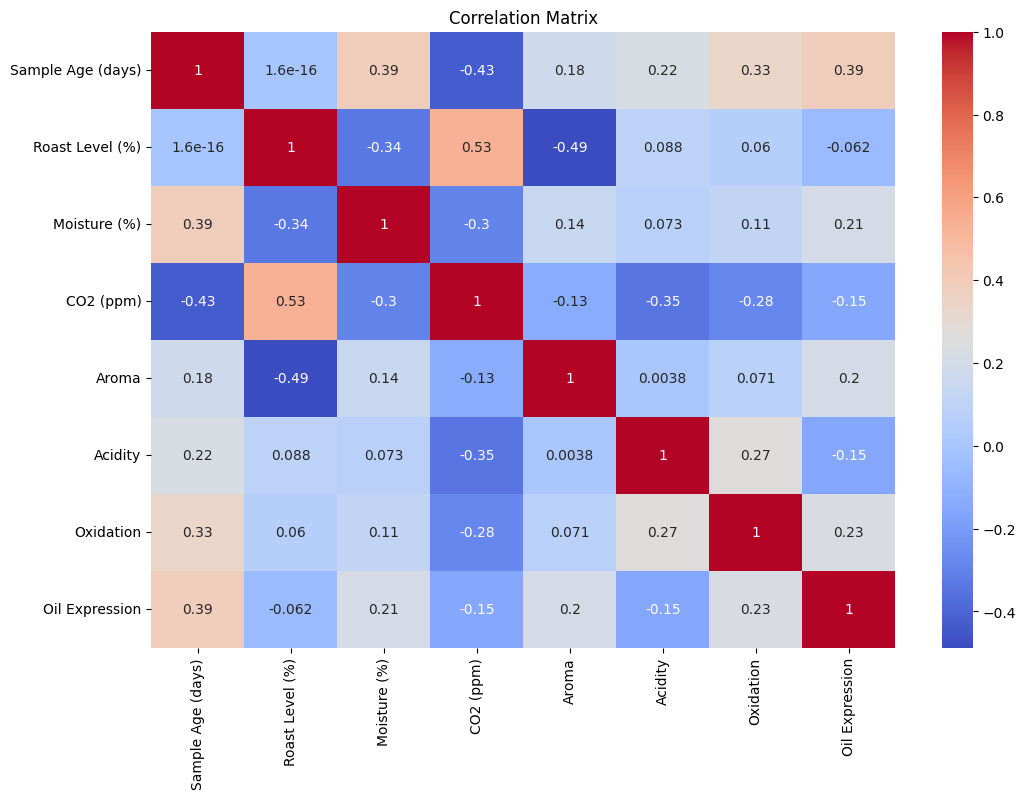

            feature1           feature2  correlation
0  Sample Age (days)  Sample Age (days)          1.0
1    Roast Level (%)    Roast Level (%)          1.0
2       Moisture (%)       Moisture (%)          1.0
3          CO2 (ppm)          CO2 (ppm)          1.0
4              Aroma              Aroma          1.0
5            Acidity            Acidity          1.0
6          Oxidation          Oxidation          1.0
7     Oil Expression     Oil Expression          1.0


In [ ]:
# We can now relook at the heat map and the significant correlations to make sure that
# there are no correlations between the features that are going to be close
# to 1.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(df.head())

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Analyze significant correlations
significant_correlations = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
significant_correlations = significant_correlations.stack().reset_index()
significant_correlations.columns = ['feature1', 'feature2', 'correlation']
print(significant_correlations)

In [ ]:
# Finally, we can normalize the dataframe. There are a lot of different
# numerical categories in this dataframe, and making sure that they are normalized
# will improve the accuracy of the model and prevent it from being skewed by numbers
# that are very different in magnitude.

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming 'df' is your DataFrame and you want to normalize all columns
scaler = MinMaxScaler()

# Normalize the DataFrame
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Display the normalized DataFrame
print(df)

    Sample Age (days)  Roast Level (%)  Moisture (%)  CO2 (ppm)     Aroma  \
0            0.000000              0.0      0.714286   0.096779  0.000000   
1            0.000000              0.0      0.571429   0.111324  0.000000   
2            0.000000              0.0      0.714286   0.082979  0.000000   
3            0.000000              1.0      0.571429   1.000000  0.555824   
4            0.000000              1.0      0.428571   0.971690  0.219570   
5            0.000000              1.0      0.571429   0.950511  0.370415   
6            0.095238              0.0      0.571429   0.046864  0.662144   
7            0.095238              0.0      0.571429   0.052895  1.000000   
8            0.095238              0.0      0.285714   0.045835  0.538272   
9            0.095238              1.0      0.714286   0.343515  0.100553   
10           0.095238              1.0      0.428571   0.294913  0.112209   
11           0.095238              1.0      0.714286   0.267170  0.106697   

In [ ]:
# Before moving on, we are going to look at the dataframe again and make sure that
# all of the data is still present.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sample Age (days)  48 non-null     float64
 1   Roast Level (%)    48 non-null     float64
 2   Moisture (%)       48 non-null     float64
 3   CO2 (ppm)          48 non-null     float64
 4   Aroma              48 non-null     float64
 5   Acidity            48 non-null     float64
 6   Oxidation          48 non-null     float64
 7   Oil Expression     48 non-null     float64
dtypes: float64(8)
memory usage: 3.1 KB


## Step 2: Pick and validate a machine learning model

There are a large variety of machine learning models. Without trying a couple of the models, we have no way of knowing which one is correct. So, I will be trying five different machine learning models and seeing which one is the most accurate.

There are models that are better and worse at certain things. I am going to be choosing models that are better at working with numerical data and working with small datasets. The five models that I have chosen to examine are as follows:

1. Linear Regression (Linear Model)
2. k-Nearest Neighbors (k-NN) (Instance-Based Learning)
3. Decision Tree (Tree-Based Model)
4. Support Vector Machine (SVM) (Support Vector Model)
5. Gradient Boosting Machine (XGBoost) (Ensemble Model)

                    Model  Train R²   Test R²      RMSE       MAE
0       Linear Regression  0.535866  0.222211  0.252118  0.228103
1     k-Nearest Neighbors  0.412200  0.290455  0.240804  0.191429
2           Decision Tree  0.830620  0.464484  0.209199  0.166667
3  Support Vector Machine  0.833330  0.206174  0.254704  0.163183
4       Gradient Boosting  0.999980  0.801135  0.127483  0.100711

Best model based on Test R² performance:
Model       Gradient Boosting
Train R²              0.99998
Test R²              0.801135
RMSE                 0.127483
MAE                  0.100711
Name: 4, dtype: object


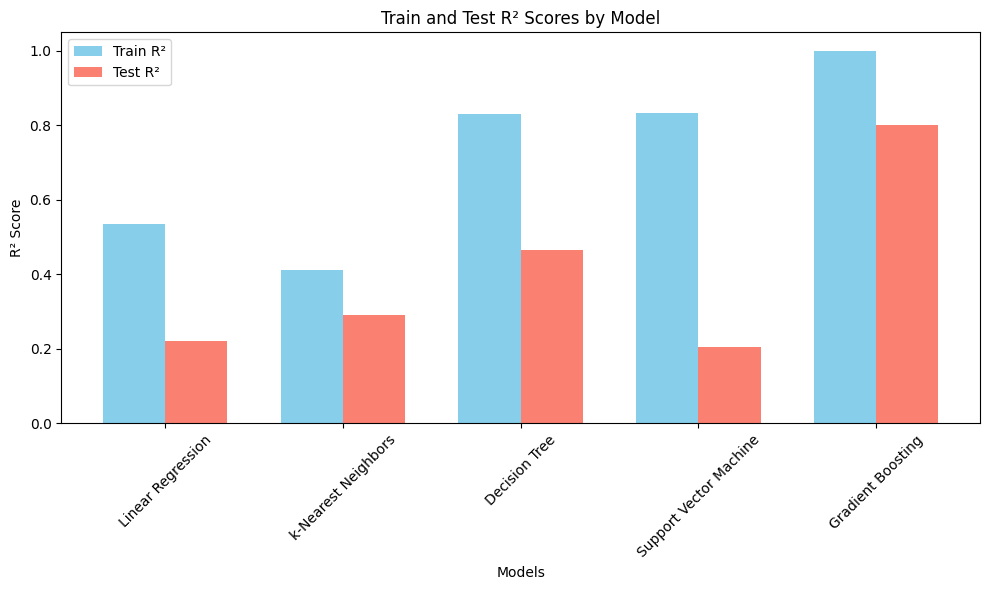

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Replace 'df' with your actual DataFrame name and specify your feature (X) and target (y) columns
X = df.drop(columns='Sample Age (days)')  # Replace 'target' with the name of your target column
y = df['Sample Age (days)']  # Replace 'target' with the name of your target column

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Define models
models = {
    'Linear Regression': LinearRegression(),
    'k-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Support Vector Machine': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Initialize results list
results = []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)

    # Store results
    results.append({
        'Model': model_name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'RMSE': rmse,
        'MAE': mae
    })

# Create a DataFrame to display results
results_df = pd.DataFrame(results)
print(results_df)

# Select the best model based on Test R², or lowest RMSE if R² is identical
best_model_row = results_df.loc[results_df['Test R²'].idxmax()]

print("\nBest model based on Test R² performance:")
print(best_model_row)

# Assuming 'results_df' is the DataFrame containing the model performance metrics
models = results_df['Model']
train_r2 = results_df['Train R²']
test_r2 = results_df['Test R²']

# Set up bar width and positions for each group
bar_width = 0.35
index = np.arange(len(models))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Train R²
train_bars = ax.bar(index, train_r2, bar_width, label='Train R²', color='skyblue')

# Bars for Test R²
test_bars = ax.bar(index + bar_width, test_r2, bar_width, label='Test R²', color='salmon')

# Labels and Titles
ax.set_xlabel('Models')
ax.set_ylabel('R² Score')
ax.set_title('Train and Test R² Scores by Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

According to the above testing of the 5 models, I am going to continue
forward with the Gradient Boosting model. This model had the best outcomes in terms
of accuracy, so we want to continue with it.

Train R² scores for each fold: [0.9999801564547789, 0.9999150163630091, 0.9999354405978949, 0.9999779996046327, 0.9998919152170832]
Test R² scores for each fold: [0.8185583363904192, 0.4836801661198218, 0.5725426858509929, 0.8653787232777342, 0.8482590442163666]
Train RMSE scores for each fold: [0.0015280599863804977, 0.0030078348619658533, 0.0026848171475431257, 0.0015329048267278757, 0.0034724983802975388]
Test RMSE scores for each fold: [0.12177036449827908, 0.2409799709428021, 0.21572125318451174, 0.13206621264989632, 0.12580880254693164]
Train MAE scores for each fold: [0.001151489043654579, 0.0022486208377361498, 0.0019688231924667073, 0.0012143964917089949, 0.002497557560335962]
Test MAE scores for each fold: [0.0945166532034383, 0.200122691987137, 0.13202536941616735, 0.06089538975008262, 0.08125093182717483]


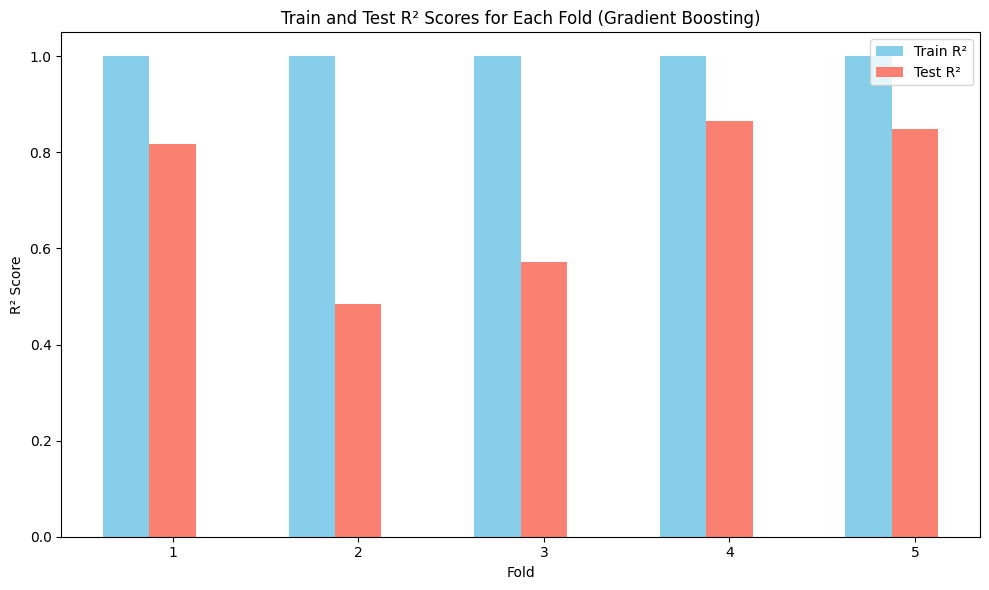

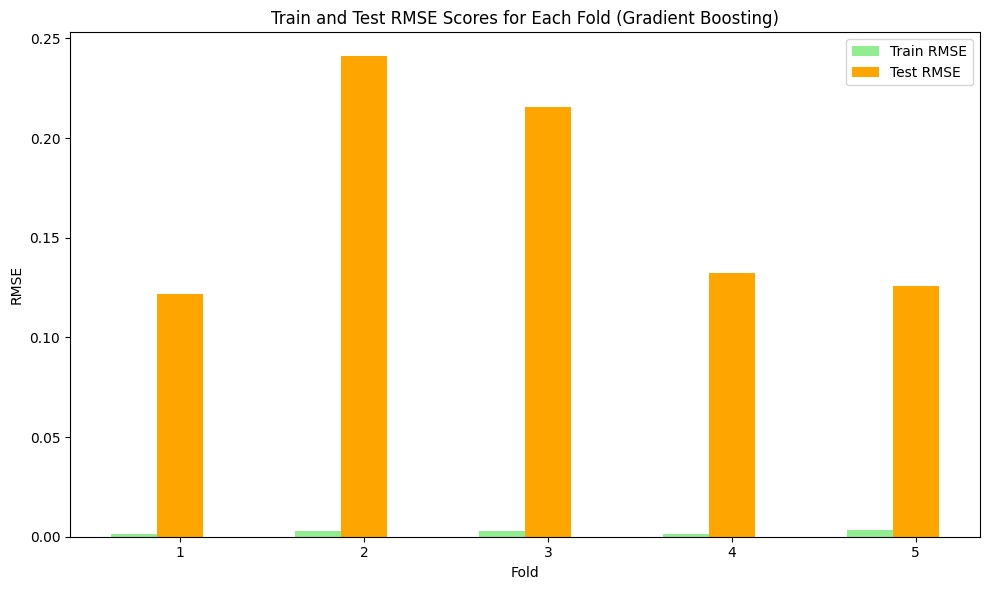

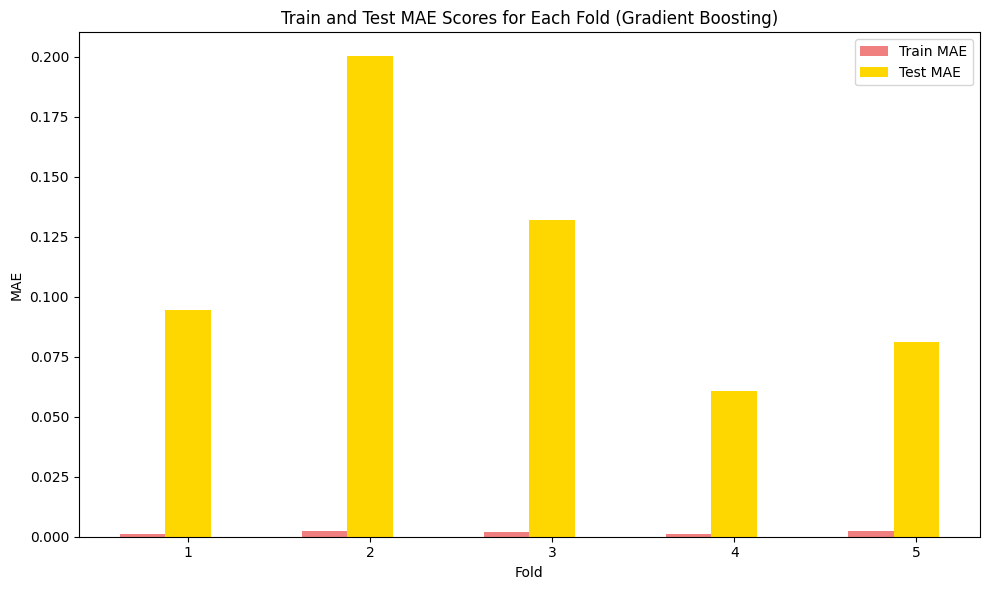

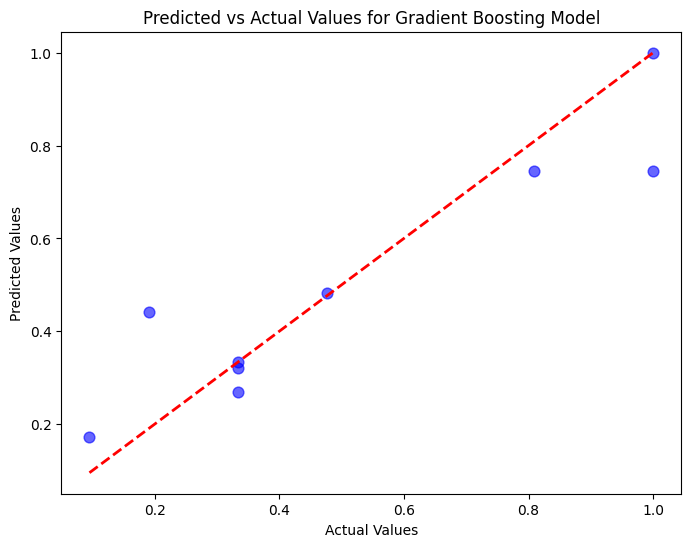

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the Gradient Boosting model
gb_model = GradientBoostingRegressor()

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store R², RMSE, and MAE scores for each fold
train_r2_scores = []
test_r2_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    # Split data into train and test for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    gb_model.fit(X_train, y_train)

    # Predict and calculate R², RMSE, and MAE for train and test sets
    train_r2_scores.append(r2_score(y_train, gb_model.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, gb_model.predict(X_test)))

    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, gb_model.predict(X_train))))
    test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test))))

    train_mae_scores.append(mean_absolute_error(y_train, gb_model.predict(X_train)))
    test_mae_scores.append(mean_absolute_error(y_test, gb_model.predict(X_test)))

# Display R², RMSE, and MAE for each fold
print("Train R² scores for each fold:", train_r2_scores)
print("Test R² scores for each fold:", test_r2_scores)
print("Train RMSE scores for each fold:", train_rmse_scores)
print("Test RMSE scores for each fold:", test_rmse_scores)
print("Train MAE scores for each fold:", train_mae_scores)
print("Test MAE scores for each fold:", test_mae_scores)

# Plotting the R² scores for each fold
folds = np.arange(1, kf.get_n_splits() + 1)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25

# Bars for Train R²
train_bars = ax.bar(folds - bar_width, train_r2_scores, bar_width, label='Train R²', color='skyblue')

# Bars for Test R²
test_bars = ax.bar(folds, test_r2_scores, bar_width, label='Test R²', color='salmon')

# Labels and Titles
ax.set_xlabel('Fold')
ax.set_ylabel('R² Score')
ax.set_title('Train and Test R² Scores for Each Fold (Gradient Boosting)')
ax.set_xticks(folds)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

# Plotting the RMSE scores for each fold
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Train RMSE
train_rmse_bars = ax.bar(folds - bar_width, train_rmse_scores, bar_width, label='Train RMSE', color='lightgreen')

# Bars for Test RMSE
test_rmse_bars = ax.bar(folds, test_rmse_scores, bar_width, label='Test RMSE', color='orange')

# Labels and Titles
ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('Train and Test RMSE Scores for Each Fold (Gradient Boosting)')
ax.set_xticks(folds)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

# Plotting the MAE scores for each fold
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Train MAE
train_mae_bars = ax.bar(folds - bar_width, train_mae_scores, bar_width, label='Train MAE', color='lightcoral')

# Bars for Test MAE
test_mae_bars = ax.bar(folds, test_mae_scores, bar_width, label='Test MAE', color='gold')

# Labels and Titles
ax.set_xlabel('Fold')
ax.set_ylabel('MAE')
ax.set_title('Train and Test MAE Scores for Each Fold (Gradient Boosting)')
ax.set_xticks(folds)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

# Make predictions on the entire test set from the last fold
y_pred = gb_model.predict(X_test)

# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for y=x

# Labels and Titles
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for Gradient Boosting Model')

plt.show()


## Step 3: Hyperparameter training

The R2 here is ok, but it could be improved in order to make a more accurate model. Something that we can do in order to make the model more accurate is that we can use hyperparameter training.

To do this, I am going to be looking at 3 different types of hyperparameter training models: grid search, random search, and Bayasian optimization. The best of these three models can then be used going forward.

In [ ]:
pip install scikit-optimize

Best parameters from Grid Search: {'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__min_samples_split': 10, 'gb__n_estimators': 50, 'gb__subsample': 0.8}
Best parameters from Randomized Search: {'gb__subsample': 1.0, 'gb__n_estimators': 100, 'gb__min_samples_split': 2, 'gb__max_depth': 3, 'gb__learning_rate': 0.2}


/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [0.8, 1.0] was inferred to Real(low=0.8, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.8, 1.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [0.8, 1.0] was inferred to Real(low=0.8, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.8, 1.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [0.8, 1.0] was inferred to Real(low=0.8, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will b

Best parameters from Bayesian Optimization: OrderedDict([('gb__learning_rate', 0.2), ('gb__max_depth', 3), ('gb__min_samples_split', 10), ('gb__n_estimators', 100), ('gb__subsample', 0.9928297312785445)])
Grid Search Training R²: 1.0
Grid Search Test R²: 0.741
Randomized Search Training R²: 1.0
Randomized Search Test R²: 0.843
Bayesian Optimization Training R²: 1.0
Bayesian Optimization Test R²: 0.848


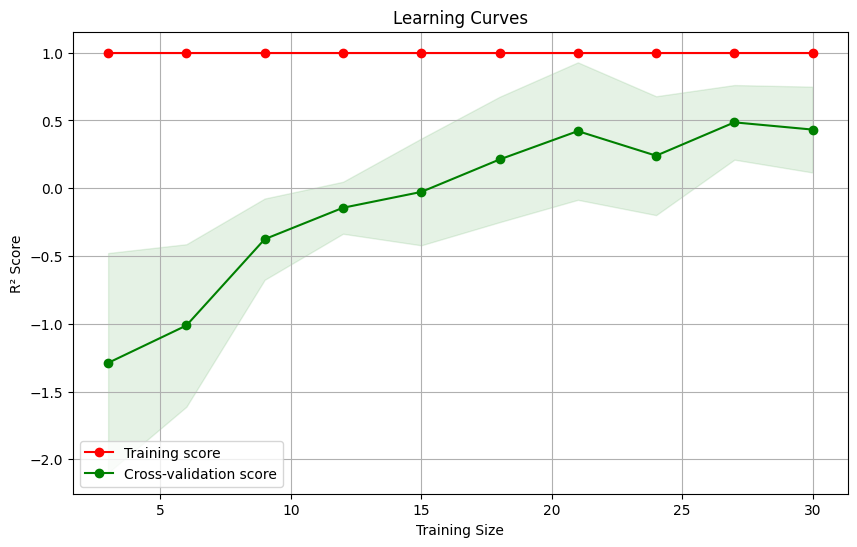

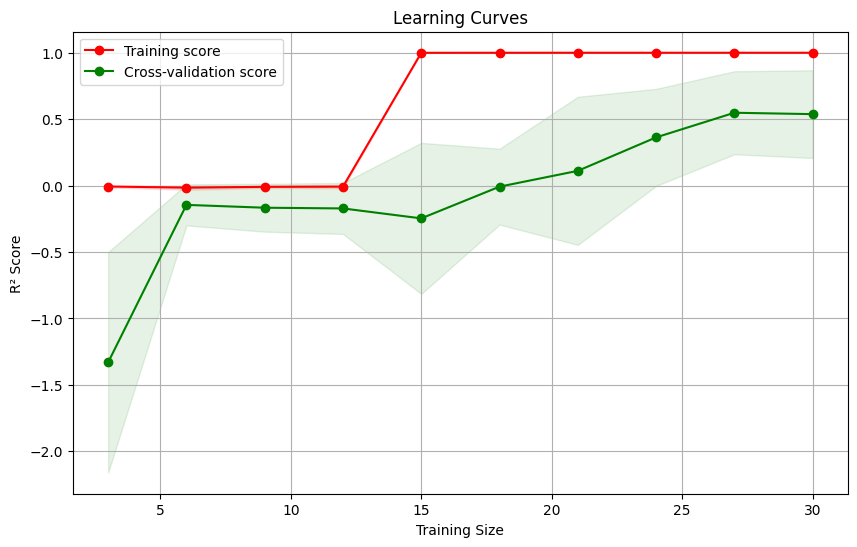

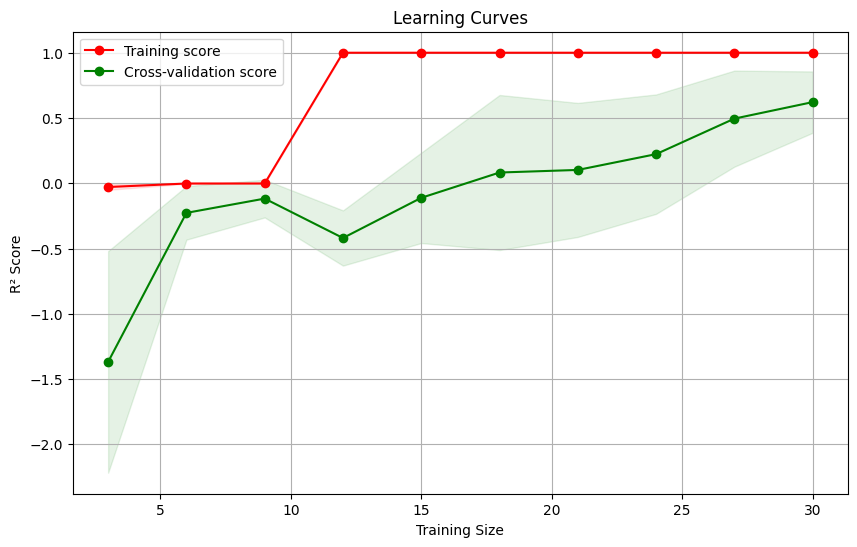

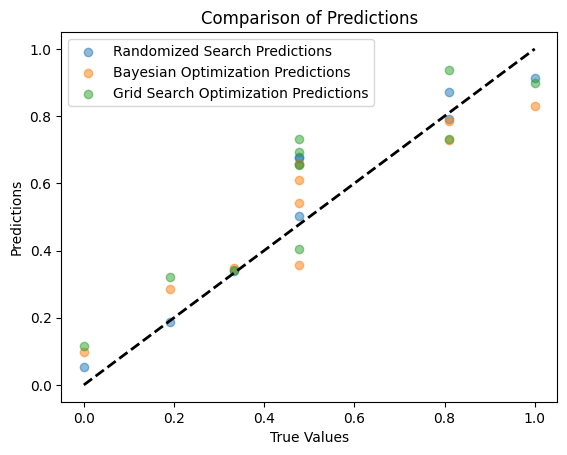

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from skopt import BayesSearchCV  # Import for Bayesian Optimization

# Create a function to plot learning curves
def plot_learning_curve(model, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation for training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Calculate the mean and standard deviation for test scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    # Plot the std deviation as a shaded area
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.title('Learning Curves')
    plt.xlabel('Training Size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Load your dataset here
# df = pd.read_csv('your_data.csv')  # Example: load your data

# Specify your features (X) and target (y)
X = df.drop(columns='Sample Age (days)')  # Adjust as needed
y = df['Sample Age (days)']  # Adjust as needed

# Create a pipeline for scaling and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor())
])

# Expanded parameter grid for Gradient Boosting
param_grid = {
    'gb__n_estimators': [50, 100, 150, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'gb__max_depth': [3, 5, 7, 9],
    'gb__subsample': [0.8, 1.0],
    'gb__min_samples_split': [2, 5, 10]
}

# Set up Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print("Best parameters from Grid Search:", grid_search.best_params_)
best_model_grid = grid_search.best_estimator_

# Set up Randomized Search with more iterations
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, cv=5, scoring='r2', random_state=42)
random_search.fit(X, y)

print("Best parameters from Randomized Search:", random_search.best_params_)
best_model_random = random_search.best_estimator_

# Set up Bayesian Optimization with more iterations
bayes_search = BayesSearchCV(pipeline, param_grid, n_iter=50, cv=5, scoring='r2', random_state=42)
bayes_search.fit(X, y)

print("Best parameters from Bayesian Optimization:", bayes_search.best_params_)
best_model_bayes = bayes_search.best_estimator_

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the best model from Grid Search on the training data
best_model_grid.fit(X_train, y_train)
y_train_pred_grid = best_model_grid.predict(X_train)
y_test_pred_grid = best_model_grid.predict(X_test)

# Calculate R² scores for Grid Search model
train_r2_grid = round(r2_score(y_train, y_train_pred_grid), 3)
test_r2_grid = round(r2_score(y_test, y_test_pred_grid), 3)
print("Grid Search Training R²:", train_r2_grid)
print("Grid Search Test R²:", test_r2_grid)

# Fit the best model from Randomized Search on the training data
best_model_random.fit(X_train, y_train)
y_train_pred_random = best_model_random.predict(X_train)
y_test_pred_random = best_model_random.predict(X_test)

# Calculate R² scores for Randomized Search model
train_r2_random = round(r2_score(y_train, y_train_pred_random), 3)
test_r2_random = round(r2_score(y_test, y_test_pred_random), 3)
print("Randomized Search Training R²:", train_r2_random)
print("Randomized Search Test R²:", test_r2_random)

# Fit the best model from Bayesian Optimization on the training data
best_model_bayes.fit(X_train, y_train)
y_train_pred_bayes = best_model_bayes.predict(X_train)
y_test_pred_bayes = best_model_bayes.predict(X_test)

# Calculate R² scores for Bayesian Optimization model
train_r2_bayes = round(r2_score(y_train, y_train_pred_bayes), 3)
test_r2_bayes = round(r2_score(y_test, y_test_pred_bayes), 3)
print("Bayesian Optimization Training R²:", train_r2_bayes)
print("Bayesian Optimization Test R²:", test_r2_bayes)

# Use the best model from each search to plot learning curves
plot_learning_curve(best_model_random, X_train, y_train)
plot_learning_curve(best_model_grid, X_train, y_train)
plot_learning_curve(best_model_bayes, X_train, y_train)

# Compare predictions
plt.scatter(y_test, y_test_pred_random, label='Randomized Search Predictions', alpha=0.5)
plt.scatter(y_test, y_test_pred_bayes, label='Bayesian Optimization Predictions', alpha=0.5)
plt.scatter(y_test, y_test_pred_grid, label='Grid Search Optimization Predictions', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.title('Comparison of Predictions')
plt.show()


Based on the hyperparameter tuning, the best model that came out of this is the Bayasian Optimization predictions. This is able to accurto have a higher test and training R2 value, so I will be using this model going forward.

Train R² scores for each fold: [0.999997553755378, 0.9999986023105527, 0.999997413857792, 0.9999974281182115, 0.9999942724646318]
Test R² scores for each fold: [0.918586289079643, 0.556113218795206, 0.5110181487970366, 0.9317341479302328, 0.8519247702562298]
Train RMSE scores for each fold: [0.000536513572208561, 0.00038573733446613923, 0.000537354839194655, 0.000524113625785107, 0.0007993623044416679]
Test RMSE scores for each fold: [0.08156838653279753, 0.22343831600841257, 0.230724082922624, 0.09404519875421537, 0.12427988098163956]
Train MAE scores for each fold: [0.00045091835242531817, 0.00031001651361522715, 0.00045140675898979886, 0.00042972150097557807, 0.0006926189286568646]
Test MAE scores for each fold: [0.06683421602402198, 0.19419538016963883, 0.13657743072382206, 0.0634657893174036, 0.0705276893000123]
Average Train R² 0.9999970541013132
Average Test R² 0.7538753149716696
Average Train RSME 0.0005566163352192261
Average Test RSME 0.1508111730399378
Average Train MAE 0.00

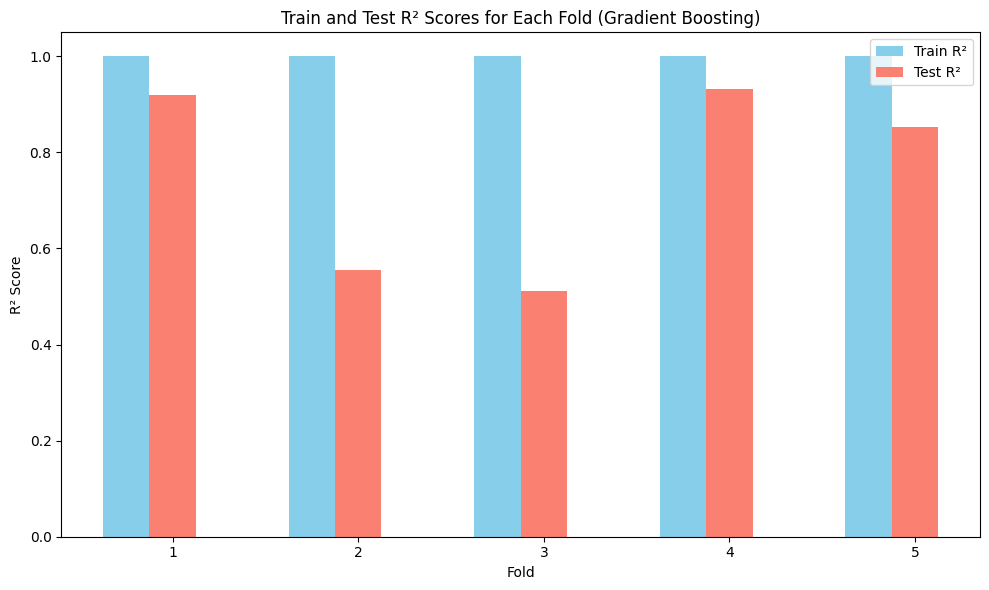

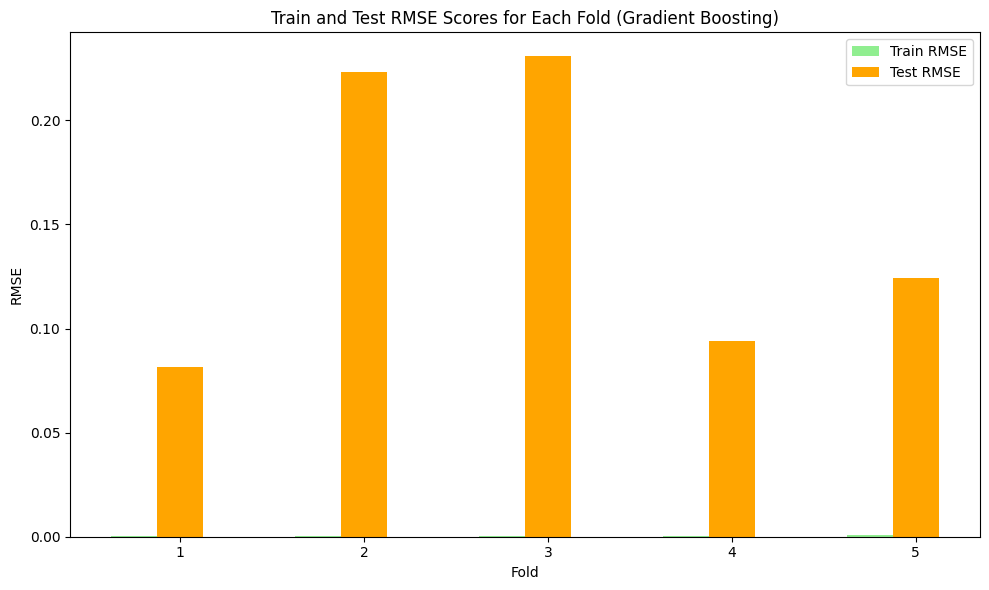

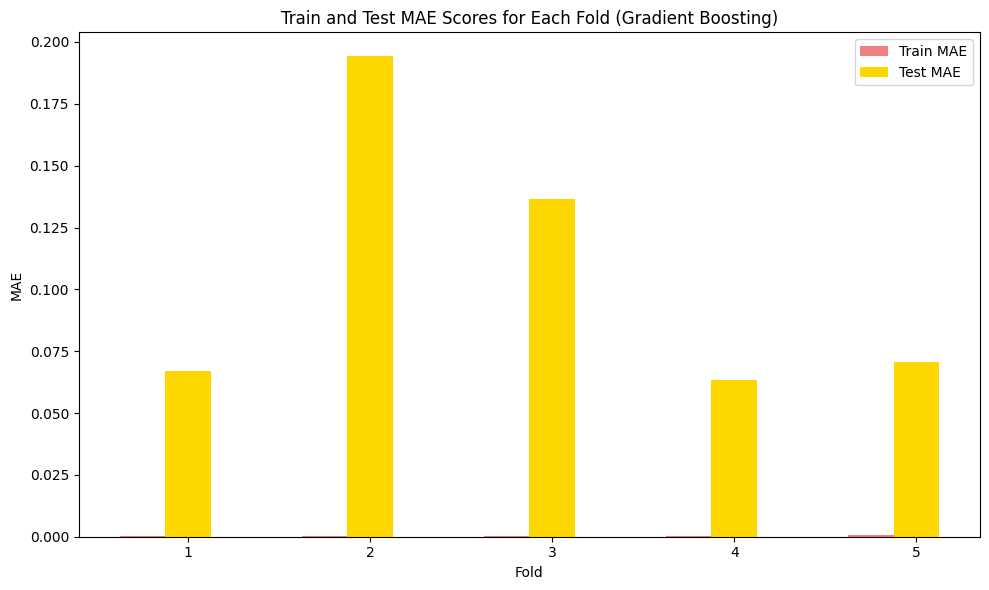

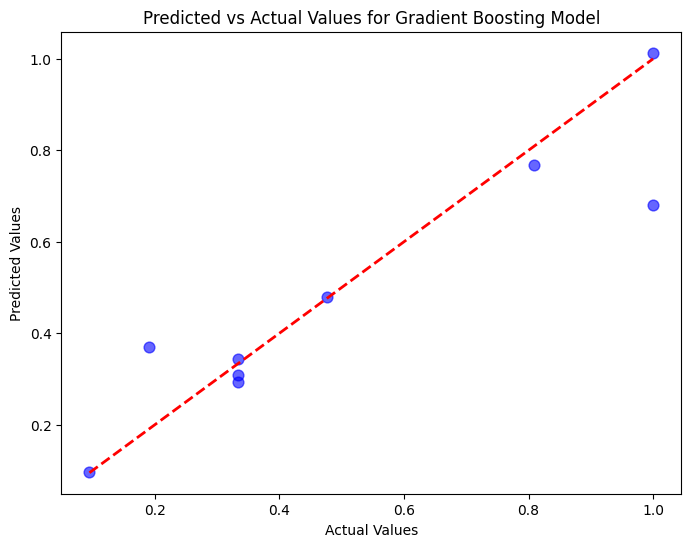

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define the Gradient Boosting model as the hypertuned model
gb_model = best_model_bayes

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store R², RMSE, and MAE scores for each fold
train_r2_scores = []
test_r2_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    # Split data into train and test for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    gb_model.fit(X_train, y_train)

    # Predict and calculate R², RMSE, and MAE for train and test sets
    train_r2_scores.append(r2_score(y_train, gb_model.predict(X_train)))
    test_r2_scores.append(r2_score(y_test, gb_model.predict(X_test)))

    train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, gb_model.predict(X_train))))
    test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, gb_model.predict(X_test))))

    train_mae_scores.append(mean_absolute_error(y_train, gb_model.predict(X_train)))
    test_mae_scores.append(mean_absolute_error(y_test, gb_model.predict(X_test)))

# Display R², RMSE, and MAE for each fold
print("Train R² scores for each fold:", train_r2_scores)
print("Test R² scores for each fold:", test_r2_scores)
print("Train RMSE scores for each fold:", train_rmse_scores)
print("Test RMSE scores for each fold:", test_rmse_scores)
print("Train MAE scores for each fold:", train_mae_scores)
print("Test MAE scores for each fold:", test_mae_scores)

print("Average Train R²", sum(train_r2_scores)/len(train_r2_scores))
print("Average Test R²", sum(test_r2_scores)/len(test_r2_scores))
print("Average Train RSME", sum(train_rmse_scores)/len(train_rmse_scores))
print("Average Test RSME", sum(test_rmse_scores)/len(test_rmse_scores))
print("Average Train MAE", sum(train_mae_scores)/len(train_mae_scores))
print("Average Test MAE", sum(test_mae_scores)/len(test_mae_scores))

# Plotting the R² scores for each fold
folds = np.arange(1, kf.get_n_splits() + 1)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25

# Bars for Train R²
train_bars = ax.bar(folds - bar_width, train_r2_scores, bar_width, label='Train R²', color='skyblue')

# Bars for Test R²
test_bars = ax.bar(folds, test_r2_scores, bar_width, label='Test R²', color='salmon')

# Labels and Titles
ax.set_xlabel('Fold')
ax.set_ylabel('R² Score')
ax.set_title('Train and Test R² Scores for Each Fold (Gradient Boosting)')
ax.set_xticks(folds)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

# Plotting the RMSE scores for each fold
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Train RMSE
train_rmse_bars = ax.bar(folds - bar_width, train_rmse_scores, bar_width, label='Train RMSE', color='lightgreen')

# Bars for Test RMSE
test_rmse_bars = ax.bar(folds, test_rmse_scores, bar_width, label='Test RMSE', color='orange')

# Labels and Titles
ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('Train and Test RMSE Scores for Each Fold (Gradient Boosting)')
ax.set_xticks(folds)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

# Plotting the MAE scores for each fold
fig, ax = plt.subplots(figsize=(10, 6))

# Bars for Train MAE
train_mae_bars = ax.bar(folds - bar_width, train_mae_scores, bar_width, label='Train MAE', color='lightcoral')

# Bars for Test MAE
test_mae_bars = ax.bar(folds, test_mae_scores, bar_width, label='Test MAE', color='gold')

# Labels and Titles
ax.set_xlabel('Fold')
ax.set_ylabel('MAE')
ax.set_title('Train and Test MAE Scores for Each Fold (Gradient Boosting)')
ax.set_xticks(folds)
ax.legend()

# Display plot
plt.tight_layout()
plt.show()

# Make predictions on the entire test set from the last fold
y_pred = gb_model.predict(X_test)

# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for y=x

# Labels and Titles
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for Gradient Boosting Model')

plt.show()


## Step 4: Increase the accuracy of the model

If the model has a lower accuracy, you can take additional steps to increase teh accuracy of the model. At this point, the model has a decent accuracy and I don't believe that addtional steps, like GAN, would be worth the time that it would require to do them. So, for now, I am going to not do this step.

In the future as this research continues, GAN might become a more useful tool to use as the dataset develops.

## Step 5: Interpotable Analysis

In [ ]:
pip install matplotlib seaborn scikit-learn

<Figure size 800x600 with 0 Axes>

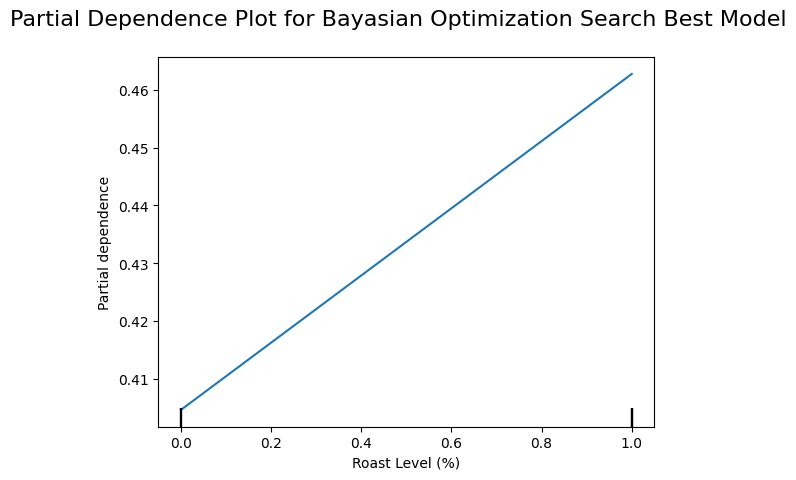

<Figure size 800x600 with 0 Axes>

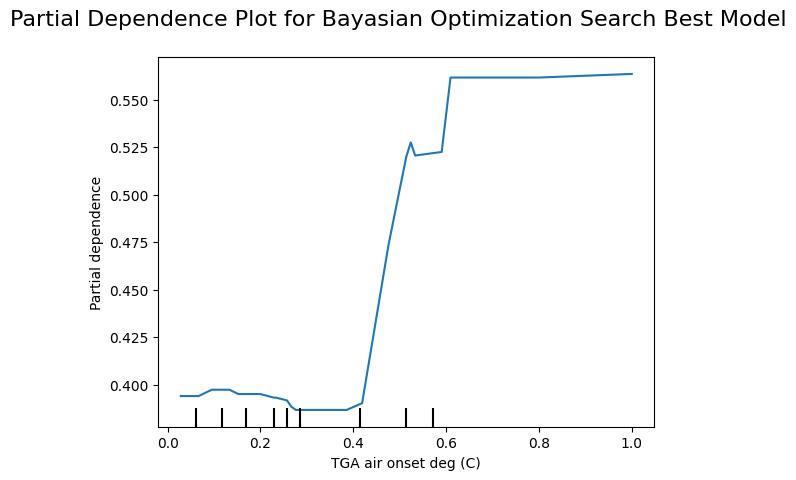

<Figure size 800x600 with 0 Axes>

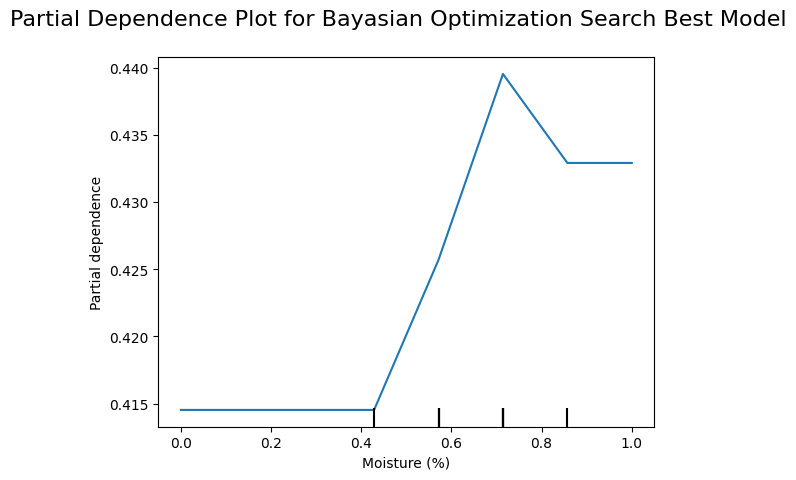

<Figure size 800x600 with 0 Axes>

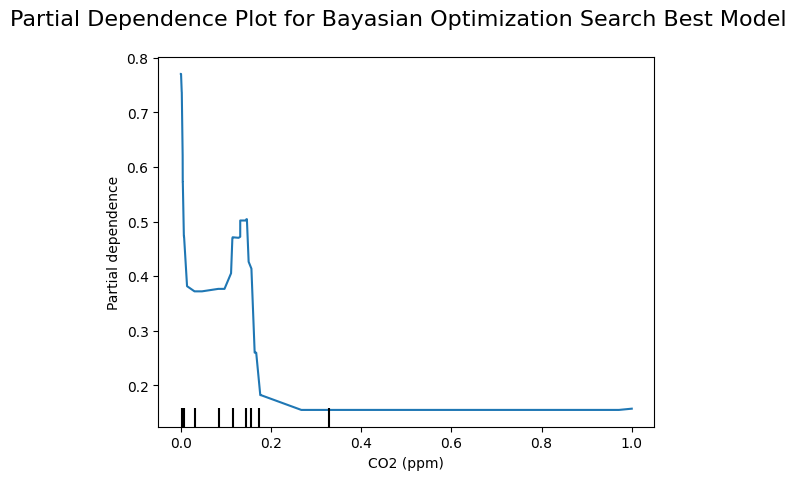

<Figure size 800x600 with 0 Axes>

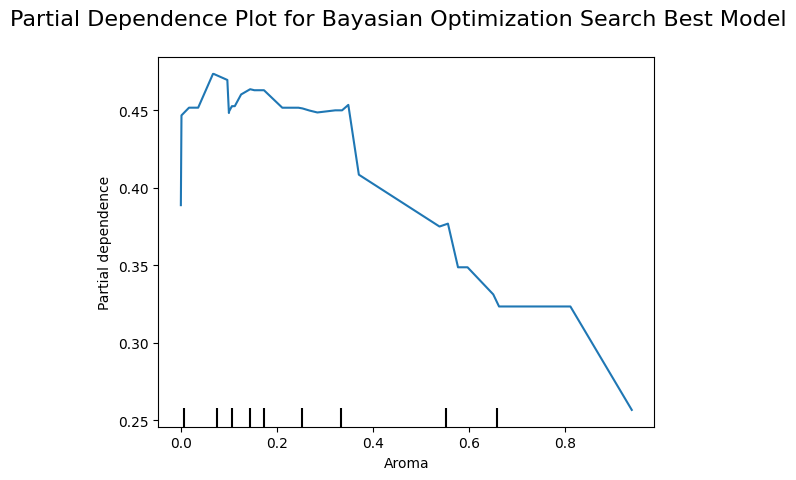

<Figure size 800x600 with 0 Axes>

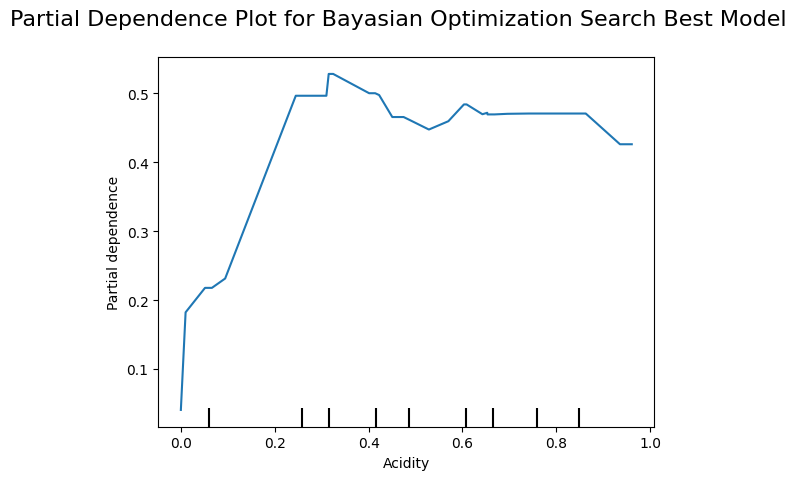

<Figure size 800x600 with 0 Axes>

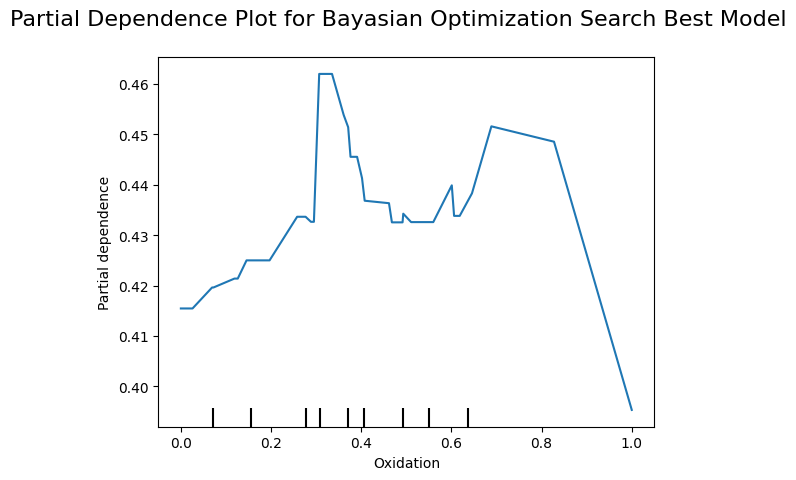

<Figure size 800x600 with 0 Axes>

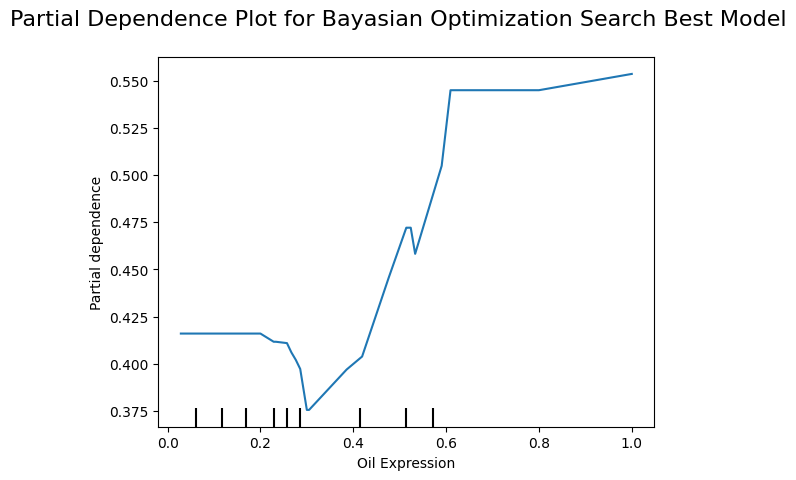

In [ ]:
# Required Libraries for Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Fit the best model from Randomized Search on the entire training data
best_model_bayes.fit(X_train, y_train)

# Select the features for which you want to create the PDP
features_to_plot = X.columns.tolist()  # Use all features; modify if you want to limit

# Create Partial Dependence Plots for each feature separately
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    display = PartialDependenceDisplay.from_estimator(
        best_model_bayes,
        X_train,
        features=[feature],  # Pass a list with the current feature
        grid_resolution=50
    )

    # Set axis labels and title
    ax.set_xlabel(feature)
    ax.set_ylabel('Partial Dependence')
    ax.set_title(f'Partial Dependence of {feature}')

    plt.suptitle('Partial Dependence Plot for Bayasian Optimization Search Best Model', fontsize=16)
    plt.show()  # Display the plot


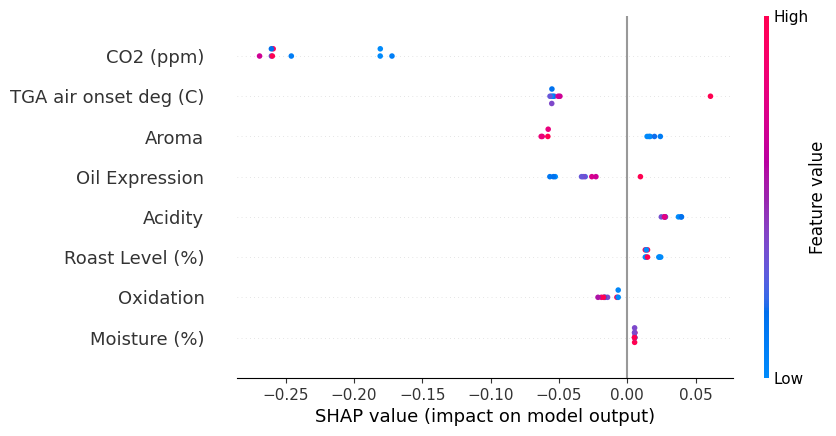

In [ ]:
import shap
import matplotlib.pyplot as plt

# Assuming you have a trained model and test data
model = best_model_bayes  # Your trained model

# Extract the actual model from the pipeline
gradient_boosting_model = model.named_steps['gb']

# Use TreeExplainer for the extracted tree-based model
explainer = shap.TreeExplainer(gradient_boosting_model)

# Calculate SHAP values for the test data
shap_values = explainer(X_test)  # For regression, use explainer(X_test)

# Create the beeswarm plot
shap.plots.beeswarm(shap_values)
plt.show()


## Step 6: Create a User Interface

Now I can create a user interface for this machine learning model. The goal of this platform is to have people enter in values for their specific type of coffee and get an output for how old their beans will be with that specific qualities.

To do this I will be making a Hugging Face app that will allow users to put in their desired qualities. It will then let them know how old the beans will be when they have those qualities.

In [ ]:
# CODE TO EXPORT THE MODELS INTO PICKLE FILES

import pickle
from sklearn.preprocessing import StandardScaler

# Initialize and fit the StandardScaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# Save the fitted scaler to a file using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler saved to 'scaler.pkl'")

# Save the best model
with open('best_model_bayes.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved to 'model.pkl'")

Scaler saved to 'scaler.pkl'
Model saved to 'model.pkl'


In [ ]:
import gradio as gr
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load models
with open('best_model_bayes.pkl', 'rb') as f:
    best_model_bayes = pickle.load(f)

# Load the pre-fitted scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define the actual output range (replace with the true range of your data)
output_min, output_max = 0, 100  # Replace with your actual denormalization values

def denormalize(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

def predict(Moisture, CO2, Aroma, Acidity, Oxidation, Oils, Roast_Level):

    # Encode the Roast Level as numerical value
    roast_level_encoded = 0 if Roast_Level == "13.5%" else 1

    # Prepare the input array with the new variables
    input_array = np.array([[Moisture, CO2, Aroma, Acidity, Oxidation, Oils, roast_level_encoded]])

    # Scale input values using the loaded, pre-fitted scaler
    input_scaled = scaler.transform(input_array)

    # Make prediction using the best model
    normalized_output = best_model_bayes.predict(input_scaled)[0]

    # Denormalize the prediction to reflect time
    time_output = denormalize(normalized_output, output_min, output_max)

    return round(time_output, 2)  # Rounded for readability

# Create the Gradio interface with sliders for each input variable
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.components.Slider(0, 1, step=0.01, label="Moisture (%)"),
        gr.components.Slider(0, 1, step=0.01, label="CO2 (ppm)"),
        gr.components.Slider(0, 1, step=0.01, label="Aroma"),
        gr.components.Slider(0, 1, step=0.01, label="Acidity"),
        gr.components.Slider(0, 1, step=0.01, label="Oxidation"),
        gr.components.Slider(0, 1, step=0.01, label="Oil Expression"),
        gr.components.Dropdown(choices=["13.5%", "20.7%"], label="Roast Level"),
    ],
    outputs=gr.components.Label(label="Time to reach target freshness (days)"),
    title="Coffee Freshness Prediction Model",
    description="Adjust the sliders and select the roast level to predict time.",
)

# Launch the interface
if __name__ == "__main__":
    iface.launch()


## Step 7: Ethics Analysis

When doing a machine learning project, it is important to access the ethics of the dataset, how the machine learning model was made, and the possible applications of the software. It is very important to make sure that any machine learning model you create does not harm people. Using the Deon's Ethics Checklist and the Ethics DataCAD are two ways that a data scientist can display the ethical considerations of their project. I will be doing both to create a comprehensive ethics analysis.

https://deon.drivendata.org/

### Step 7.1: Deon's Ethics Checklist

In [ ]:
# Deon's Ethics Checklist
!pip install deon

In [ ]:
# Generate the checklist using the Deon CLI in markdown format
!deon --output coffee_ethics_checklist.md --format markdown

Checklist successfully written to file coffee_ethics_checklist.md.


In [ ]:
# Read and display the generated checklist
with open('coffee_ethics_checklist.md', 'r') as file:
    checklist_content = file.read()

print(checklist_content)


# Ethics Checklist for Coffee Freshness Prediction

## A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

This dataset did not use human subjects, so there was no need for informed consent. The only human interaction with the dataset was the researchers collecting the data. These researchers, including myself 
and my research advisor Dr. Wakabayashi, both consented to the use of this data for the machine learning project. 

 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?

It is possible that the collection methods from the sureying techniques introduced in bias into the dataset. To mitigate any bias or error that was introduced into the dataset
through the collection technqiues of the study, every 

In [ ]:
# Customized Deon Ethics Checklist for Coffee Freshness Prediction

custom_checklist = """
# Ethics Checklist for Coffee Freshness Prediction

## A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

This dataset did not use human subjects, so there was no need for informed consent. The only human interaction with the dataset was the researchers collecting the data. These researchers, including myself
and my research advisor Dr. Wakabayashi, both consented to the use of this data for the machine learning project.

 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?

It is possible that the collection methods from the sureying techniques introduced in bias into the dataset. To mitigate any bias or error that was introduced into the dataset
through the collection technqiues of the study, every sample was run in triplicate. The goal of using this method was to reduce any error that could come from one
incorrect measurement.

 - [ ] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

There is no PPI present in this dataset. So, no steps were taken to limit PPI exposure because it was not relavent to this dataset.

 - [ ] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

There was no information that was collected that could have a biases result based on protected group status. However, in order to reduce any bias in the model that was generated,
all samples will always be run in triplicate if not more and any error associated with the measurements will be additionally recorded.

## B. Data Storage
 - [ ] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?

There is a plan to make sure that the dataset and code is not edited to change the dataset. The available copy of the dataset to the research group that is using the ML model has an access and edit
log so that no data is changed after the tests have been conducted. There is no plan to encrypt the data, as the dataset does not contain any private information

 - [ ] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?

There is no personal information in this dataset, so no mechanisms were put into considerations to allow people to remove personal information. In the future, as more data is
collected, this can be re-evaluated. If other people contribute data to this project, a mechanism can be added into the data analysis process that allows people to request for
their datasets to be removed. For now, this is not a feature that was added into the project because it is not relavent.

 - [ ] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?

There is no plan to delete the data after it is no longer needed. The goal with maintaining the accuracy and transparancy of the model is to keep the dataset, as well as any updates
to the dataset, are open to the public. The data does not have any personal or sensitive information about any people, so there is no worry about anyone needing to remove their information
as time passes. The only instance where data would be removed from the ML model is if new data is obtained in the lab and the old dataset was proven to be inaccurate. However, this is not a
situation that I am currently considering, because we are not close to being able to remove datapoints. This is something to consider in the future to maintain an accurate model.

## C. Analysis
 - [ ] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?

The analysis of this data relies on previous studies that have been conducted on the compounds that were measured in the coffee. It is possible that the freshness and taste characteristics
that were associated with the coffee in this analysis do not accurately reflect the way that the stakeholders taste and process the coffee, resulting in discrepancies between the user of the model
and the actual result of the mdoel. To address this, the different components were confirmed in multiple literature searches that have occurred over the past six months of development of the dataset.

The model has also been discussed with local coffee experts, including professors at Bucknell University who have studied coffee science and local roasters and coffee salespeople from the  Lewisburg and
surrounding areas. The model's results were discussed and the coffee experts helped to shed light into further characteristics of the model that needed to be developed, like additional tests that were added
throughout the collection of the dataset.

 - [ ] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?

The dataset could have bias that occurred during the sampling process. It is possible that the steps of collecting the data skewed the results. In order to adress this, each experimental method was documented and repeated by the same researcher in
triplicate. This ensured that any outliers that could have been caused by the data collection method would be recognized and could be removed if neccessary. Also, the results were confirmed by the advisor of the research group as well as checked with
other studies within the body of coffee literature.

 - [ ] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?

All visualizations, summary statistics, and reports that were created in the analysis of the dataset were designed to honestly represent the underlying data. Any figure that was generated represents the dataset. No attempts were made throughout
the analysis process to alter the figures or statistics in a way that would misrepresent the trends present in the data.

 - [ ] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?

Data with PII was not used in this dataset. So, not measures were taken to ensure that PII was not used or displayed because it was not present.

 - [ ] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

The process of generating the analysis of the dataset is present in the Google Colab file that is attached to this Github repository. The analysis and creation of the model is broken down into the steps that
were taken and is also commented to describe why certain choices were made throughout the analysis of the dataset. The goal with formatting the analysis in this way is that this code could be taken and used with an alternative dataset.
This way, another researcher or research group could repeat the process with data that they obtained. Because all decisions were documented, it is also possible to locate issues in the code and change
any parts of the model if errors arise in the future.

## D. Modeling
 - [ ] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?

 In designing the methods of collecting data for this experiment, a variety of different aspects of the coffee were considered so that one variable does not solely dictate the
 results of the ML model. In doing the pre-processing of the dataset, the goal was to make sure that the model does not only rely on one correlation that would unfairly swing the
 results of the predicted freshness. Further, no proxy variables were used because only one specific of origin was used, and the roast levels were represented numerically instead of
 categorically with words like "light" and "dark". As the model continues to be develoepd, the goal is to add more species of origin. The researchers recognize that the reigon where
 the coffee beans are grown could act as a proxy variable, and so only quantitive factors that would affect the coffee (temperature, humidity, altitude) will be considered.

 - [ ] **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?

The model has not currently been tested for fairness across different groups. The model parameters were chosen and developed from literature searches that spanned decades of research from different countries and research
groups. Because the model has not been beta tested, it is unclear if the model is calibrated in a way that would unfairly discriminate against certain groups of people that will drink the coffee or use the
model. Going forward, as the model continues into further levels of development, it is important to check with a wide variety of people to see how they interpret or are affected by the model.

 - [ ] **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?

Yes, additional metrics are going to be added as this study is continued and more data is collected. The goal is to find more variables that are strongly correlated with time,
which should make a more accurate model and predict the quality of the coffee in a more complete and thorough manner.

 - [ ] **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?

All decisions made in the creation of this model have been commented and documented, so all aspects of the model can be justified. The explainations of the model and the
choices made throughout its development were written in plain English to avoid confusion from any listeners.

 - [ ] **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?

The model only works for Brazilian Cerrado beans and for the two roast levels that have been analyzed so far. This is stated in the app for the ML model, so that any stakeholders can
understand the limitations of the dataset. Further, the accuracy of the model (R2, RMSE, MAE) were documented in the analysis process so that any stakeholders can read through the
creation of the model and decide if it is accurate enough for their specific use.

## E. Deployment
 - [ ] **E.1 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?

As a research team, the goal of this project is to be informative. However, the research team recognizes that the model is not perfectly accurate and is just one of many attempts to quantify the freshness of coffee. After deployment,
the goal is to keep in contact with any roasters or brewers who use the model and check in with how the model has been informing their decisions and if they believe that the model has been working properly. The users' feedback will be
prioritized. The goal of the ML platform is to make it easier for people to gauge how old their coffee is. If it is not achieving that goal, the model needs to be updated in order to better reflect the needs of the clients who are using
the platform.

 - [ ] **E.2 Roll back**: Is there a way to turn off or roll back the model in production if necessary?

The model is hosted on a Hugging Face app, which can be shut down at any point if deemed necessary. It is also possible to update the model while keeping the platform deployed, so any bugs that are found in
the current version of the model can be corrected. Users will only be able to access the most current version of the ML model, so users will not be able to access a worse version of the model if any updates
have been made.

 - [ ] **E.3 Concept drift**: Do we test and monitor for concept drift to ensure the model remains fair over time?

Over time, the model will continuously be trained with newly collected data. The new data will be validated on the new data and any drift from the original accuracy and fairness of the model will be corrected.
The model will be checked to make sure that the results are as consistant and accurate as possible, even as time passes since initial deployment.

 - [ ] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?

The goal of this model is to create a place where users can be informed of how their coffee ages. Because this model will only be used by local roasters and brewers (at least at initial deployment), it should be
possible to track the use of the model and make sure that roasters are not using it in a negative way (like trying to harm the sales of another roaster). If the model is being abused, it will be taken down, and
additional measures will be created to secure the model so that only those with permission can access it. For now, this seems like a step that is not needed, because the model is not being fully deployed or
recommended for use until the dataset is further developed.

"""

# Save the customized checklist to a new markdown file
with open('coffee_ethics_checklist.md', 'w') as file:
    file.write(custom_checklist)

print("Custom ethics checklist saved as 'coffee_ethics_checklist.md'")


Custom ethics checklist saved as 'coffee_ethics_checklist.md'


In Hugging Face, an app.py can be created in order to have the ethics checklist publically visible. It is important that ethics checklists for machine learning projects can be very easily accessed so that people who use the platforms developed understand any ethical concerns and considerations that come with using the model.

In [ ]:
# Upload to Hugging Face so that the checklist can be publically viewed

import gradio as gr

# Markdown content
md_content = """
# Ethics Checklist for Coffee Freshness Prediction

## A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

This dataset did not use human subjects, so there was no need for informed consent. The only human interaction with the dataset was the researchers collecting the data. These researchers, including myself
and my research advisor Dr. Wakabayashi, both consented to the use of this data for the machine learning project.

 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?

It is possible that the collection methods from the sureying techniques introduced in bias into the dataset. To mitigate any bias or error that was introduced into the dataset
through the collection technqiues of the study, every sample was run in triplicate. The goal of using this method was to reduce any error that could come from one
incorrect measurement.

 - [ ] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

There is no PPI present in this dataset. So, no steps were taken to limit PPI exposure because it was not relavent to this dataset.

 - [ ] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

There was no information that was collected that could have a biases result based on protected group status. However, in order to reduce any bias in the model that was generated,
all samples will always be run in triplicate if not more and any error associated with the measurements will be additionally recorded.

## B. Data Storage
 - [ ] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?

There is a plan to make sure that the dataset and code is not edited to change the dataset. The available copy of the dataset to the research group that is using the ML model has an access and edit
log so that no data is changed after the tests have been conducted. There is no plan to encrypt the data, as the dataset does not contain any private information

 - [ ] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?

There is no personal information in this dataset, so no mechanisms were put into considerations to allow people to remove personal information. In the future, as more data is
collected, this can be re-evaluated. If other people contribute data to this project, a mechanism can be added into the data analysis process that allows people to request for
their datasets to be removed. For now, this is not a feature that was added into the project because it is not relavent.

 - [ ] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?

There is no plan to delete the data after it is no longer needed. The goal with maintaining the accuracy and transparancy of the model is to keep the dataset, as well as any updates
to the dataset, are open to the public. The data does not have any personal or sensitive information about any people, so there is no worry about anyone needing to remove their information
as time passes. The only instance where data would be removed from the ML model is if new data is obtained in the lab and the old dataset was proven to be inaccurate. However, this is not a
situation that I am currently considering, because we are not close to being able to remove datapoints. This is something to consider in the future to maintain an accurate model.

## C. Analysis
 - [ ] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?

The analysis of this data relies on previous studies that have been conducted on the compounds that were measured in the coffee. It is possible that the freshness and taste characteristics
that were associated with the coffee in this analysis do not accurately reflect the way that the stakeholders taste and process the coffee, resulting in discrepancies between the user of the model
and the actual result of the mdoel. To address this, the different components were confirmed in multiple literature searches that have occurred over the past six months of development of the dataset.

The model has also been discussed with local coffee experts, including professors at Bucknell University who have studied coffee science and local roasters and coffee salespeople from the  Lewisburg and
surrounding areas. The model's results were discussed and the coffee experts helped to shed light into further characteristics of the model that needed to be developed, like additional tests that were added
throughout the collection of the dataset.

 - [ ] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?

The dataset could have bias that occurred during the sampling process. It is possible that the steps of collecting the data skewed the results. In order to adress this, each experimental method was documented and repeated by the same researcher in
triplicate. This ensured that any outliers that could have been caused by the data collection method would be recognized and could be removed if neccessary. Also, the results were confirmed by the advisor of the research group as well as checked with
other studies within the body of coffee literature.

 - [ ] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?

All visualizations, summary statistics, and reports that were created in the analysis of the dataset were designed to honestly represent the underlying data. Any figure that was generated represents the dataset. No attempts were made throughout
the analysis process to alter the figures or statistics in a way that would misrepresent the trends present in the data.

 - [ ] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?

Data with PII was not used in this dataset. So, not measures were taken to ensure that PII was not used or displayed because it was not present.

 - [ ] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

The process of generating the analysis of the dataset is present in the Google Colab file that is attached to this Github repository. The analysis and creation of the model is broken down into the steps that
were taken and is also commented to describe why certain choices were made throughout the analysis of the dataset. The goal with formatting the analysis in this way is that this code could be taken and used with an alternative dataset.
This way, another researcher or research group could repeat the process with data that they obtained. Because all decisions were documented, it is also possible to locate issues in the code and change
any parts of the model if errors arise in the future.

## D. Modeling
 - [ ] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?

 In designing the methods of collecting data for this experiment, a variety of different aspects of the coffee were considered so that one variable does not solely dictate the
 results of the ML model. In doing the pre-processing of the dataset, the goal was to make sure that the model does not only rely on one correlation that would unfairly swing the
 results of the predicted freshness. Further, no proxy variables were used because only one specific of origin was used, and the roast levels were represented numerically instead of
 categorically with words like "light" and "dark". As the model continues to be develoepd, the goal is to add more species of origin. The researchers recognize that the reigon where
 the coffee beans are grown could act as a proxy variable, and so only quantitive factors that would affect the coffee (temperature, humidity, altitude) will be considered.

 - [ ] **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?

The model has not currently been tested for fairness across different groups. The model parameters were chosen and developed from literature searches that spanned decades of research from different countries and research
groups. Because the model has not been beta tested, it is unclear if the model is calibrated in a way that would unfairly discriminate against certain groups of people that will drink the coffee or use the
model. Going forward, as the model continues into further levels of development, it is important to check with a wide variety of people to see how they interpret or are affected by the model.

 - [ ] **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?

Yes, additional metrics are going to be added as this study is continued and more data is collected. The goal is to find more variables that are strongly correlated with time,
which should make a more accurate model and predict the quality of the coffee in a more complete and thorough manner.

 - [ ] **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?

All decisions made in the creation of this model have been commented and documented, so all aspects of the model can be justified. The explainations of the model and the
choices made throughout its development were written in plain English to avoid confusion from any listeners.

 - [ ] **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?

The model only works for Brazilian Cerrado beans and for the two roast levels that have been analyzed so far. This is stated in the app for the ML model, so that any stakeholders can
understand the limitations of the dataset. Further, the accuracy of the model (R2, RMSE, MAE) were documented in the analysis process so that any stakeholders can read through the
creation of the model and decide if it is accurate enough for their specific use.

## E. Deployment
 - [ ] **E.1 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?

As a research team, the goal of this project is to be informative. However, the research team recognizes that the model is not perfectly accurate and is just one of many attempts to quantify the freshness of coffee. After deployment,
the goal is to keep in contact with any roasters or brewers who use the model and check in with how the model has been informing their decisions and if they believe that the model has been working properly. The users' feedback will be
prioritized. The goal of the ML platform is to make it easier for people to gauge how old their coffee is. If it is not achieving that goal, the model needs to be updated in order to better reflect the needs of the clients who are using
the platform.

 - [ ] **E.2 Roll back**: Is there a way to turn off or roll back the model in production if necessary?

The model is hosted on a Hugging Face app, which can be shut down at any point if deemed necessary. It is also possible to update the model while keeping the platform deployed, so any bugs that are found in
the current version of the model can be corrected. Users will only be able to access the most current version of the ML model, so users will not be able to access a worse version of the model if any updates
have been made.

 - [ ] **E.3 Concept drift**: Do we test and monitor for concept drift to ensure the model remains fair over time?

Over time, the model will continuously be trained with newly collected data. The new data will be validated on the new data and any drift from the original accuracy and fairness of the model will be corrected.
The model will be checked to make sure that the results are as consistant and accurate as possible, even as time passes since initial deployment.

 - [ ] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?

The goal of this model is to create a place where users can be informed of how their coffee ages. Because this model will only be used by local roasters and brewers (at least at initial deployment), it should be
possible to track the use of the model and make sure that roasters are not using it in a negative way (like trying to harm the sales of another roaster). If the model is being abused, it will be taken down, and
additional measures will be created to secure the model so that only those with permission can access it. For now, this seems like a step that is not needed, because the model is not being fully deployed or
recommended for use until the dataset is further developed.

"""

def display_markdown():
    return md_content

# Create a Gradio interface
iface = gr.Interface(fn=display_markdown, inputs=[], outputs="markdown")
iface.launch()


ModuleNotFoundError: No module named 'gradio'

### Step 7.2: Ethics DataCAD

In [ ]:
!pip install gradio
import gradio as gr

# Ethics DataCard content for coffee freshenss prediction model
datacard_content = """
# Ethics DataCard for Coffee Freshness Prediction Model

## Dataset Overview
- **Input Variables**: Chemical and physical characteristcs of coffee
- **Output Variables**: Time (days)

## Data Collection Process
- Data was collected over a 21 day period and documented as it was collected.
- All data samples were run in triplicate to reduce error in the dataset.

## Bias Considerations
- Potential Bias: Data only contains a Brazillian coffee, which may not be indicative of all species of coffee.
- Mitigation: For now, the model clearly states this limitation, with future plans to collect more data from different species of origin.

## Fairness & Justice
- The study aims to benefit both large and small coffee producers by providing insights that can reduce waste and improve sustainability for all stakeholders.
- Focuses on equitable outcomes by considering cost-effective methods for measuring and preserving freshness, accessible to producers of varying scales.

## Privacy and Security
- No personal or identifying information is collected; the research focuses on product-level data only.

## Sustainability and Environmental Impact
- The research emphasizes reducing coffee waste by optimizing freshness retention, directly contributing to environmental and economic sustainability.
- Reduces waste from premature disposal of roasted coffee beans.

## Model Limitations
- Model only considers Brazil cerrado coffee at two differnt raost levels.
- Freshness metrics may not capture all sensory attributes valued by diverse consumer groups.
- Results are most applicable to third-wave coffee, with limited direct application to traditional or commercial coffee practices.

## Accountability and Transparency
- Regular reviews and open communication with coffee industry stakeholders ensure the relevance and integrity of the research.
- Findings are shared in a way that promotes transparency, including limitations and potential biases in the dataset.

## Societal Impact
- By reducing waste and improving product quality, the research supports more sustainable coffee production and consumption.
- It has the potential to inform industry-wide practices, benefitting small-scale farmers, roasters, and consumers alike.
"""

# Function to display the DataCard
def display_datacard():
    return datacard_content

# Gradio interface to display the ethics DataCard
iface = gr.Interface(fn=display_datacard, inputs=[], outputs="markdown")

# Launch the Gradio interface
iface.launch()